# **Medical Symptoms Audio Classification**

This project focuses on using machine learning techniques in order to classify medical symptoms based on self-reported audio recordings, with the goal of improving conversational agents in the medical field. The dataset comprises thousands of audio snippets, totaling over 8 hours of recording time, these recordings were created through a multi-step process where contributors first provided textual descriptions of symptoms, followed by recording corresponding audio. However, challenges such as incorrect labels and poor audio quality necessitate thorough data cleaning before model training. By addressing these issues, the project aims to create robust models that can accurately classify medical symptoms, thus enhancing the efficacy of conversational agents and improving healthcare diagnosis.

**The research questions are:**

* Can we classify the symptom of the patient to cough or infected wound only by the audio file?
* Which model classify better, audio file classification model or NLP model of the audio files transcriptions?
---

# **Table of Contents**

---

#### 1. [Libraries Imports](#SectionA)

#### 2. [Exploratory Data Analysis](#SectionB)

#### 2.1. [Audio Quality Measures](#SectionC)

#### 2.2. [Personal Audio Measures](#SectionD)

#### 2.3. [Symptom - The Label](#SectionE)

#### 2.4. [Audio Recordings Features](#SectionF)

#### 2.5. [Clustering Methods](#SectionG)

# **Libraries Imports**
<a class="anchor" id="SectionImports"></a>

In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
!pip install spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex

# Text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import wordnet
import re

# Audio
import librosa
import os
import IPython

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# **EDA and Feature Engineering**
<a class="anchor" id="SectionEDA"></a>

In [3]:
class EDAClass:
  def __init__(self, filepath, audio_dir, binary_outcome = True):
    """
    Initializes the EDAObject with the given file path and audio directory.

    Args:
      filepath (str): Path to the CSV file containing the data.
      audio_dir (str): Directory where audio files are stored.
      binary_outcome (bool): If True, subset the data to only include "Cough" and "Infected wound".
    """
    self.audio_dir = audio_dir
    self.data = pd.read_csv(filepath)

    self.data.rename(columns={'prompt':'Symptoms'}, inplace=True)
    # Subset for binary outcome: "Cough" or "Infected Wound"
    if binary_outcome:
      self.data = self.data[((self.data['Symptoms'] == "Cough") | (self.data['Symptoms'] == "Infected wound"))]
      self.data.reset_index(drop=True, inplace=True)

    # Find and convert features to category type
    category_features = self.data.select_dtypes(include=['object']).columns.append(self.data.select_dtypes(include=['int64']).columns)
    self.data[category_features] = self.data[category_features].astype('category')
    self.data['phrase'] = self.data['phrase'].astype('string')
    self.data['file_name'] = self.data['file_name'].astype('string')

    self.X = self.data.select_dtypes(include=['float64'])
    self.y = self.data['Symptoms']

  def get_data(self):
    """
    Returns the data loaded into the EDAObject.

    Returns:
      pd.DataFrame: DataFrame containing the data.
    """
    return self.data

  def EDA_quality_measures(self):
    """
    Performs Exploratory Data Analysis (EDA) on quality measures.
    Plots frequency, histogram, and density plots for audio quality measures.
    """
    quality_measures = ['audio_clipping', 'quiet_speaker', 'background_noise_audible']

    fig, axes = plt.subplots(3, len(quality_measures), figsize=(18, 12), gridspec_kw={'height_ratios': [0.6, 3, 3]})

    for i, column in enumerate(quality_measures):
        sns.heatmap(self.data[column].value_counts().to_frame().T,
                    ax=axes[0, i], annot=True, fmt="d", cmap="Set3", cbar=False, yticklabels=False)
        axes[0, i].xaxis.tick_top()
        axes[0, i].xaxis.set_label_position('top')
        axes[0, i].set_title(column.capitalize(), fontsize=16)
        axes[0, i].set(xlabel="")
        sns.histplot(data=self.data, ax=axes[1, i], x=column+":confidence", fill=True)
        axes[1, i].set_xlim(0, 1.2)
        axes[1, i].set_ylim(0, 600)
        sns.kdeplot(data=self.data, ax=axes[2, i], x=column+":confidence", hue=column, palette="tab10", fill=True, warn_singular=False)
        axes[2, i].set_xlim(0, 1.2)
        sns.move_legend(axes[2, i], "upper left")

    fig.suptitle("Frequency, Histogram, and Density of Quality Measures", y=0.97, fontsize=20)
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    sns.histplot(data=self.data, ax=axes[0], x="overall_quality_of_the_audio", fill=True, bins=6)
    sns.kdeplot(data=self.data, ax=axes[1], x="overall_quality_of_the_audio", hue="Symptoms", fill=True, warn_singular=False)
    axes[0].set_xlim(0, 5)
    axes[1].set_xlim(0, 5)
    sns.move_legend(axes[1], "upper left")

    fig.suptitle("Histogram, and Density of the Overall Quality Measure", y=0.97, fontsize=20)
    plt.show()

  def EDA_writers_speakers(self):
    """
    Performs Exploratory Data Analysis (EDA) on writer and speaker IDs.
    Plots histograms for speaker and writer IDs.
    """
    plt.figure(figsize=(20, 6))
    self.data['speaker_id'].value_counts().plot(kind='bar')
    plt.title('Speaker ID Histogram')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(10, 4))
    self.data['writer_id'].value_counts().plot(kind='bar')
    plt.title('Writer ID Histogram')
    plt.ylabel('Count')
    plt.show()

  def EDA_symptoms(self):
    """
    Performs Exploratory Data Analysis (EDA) on symptoms.
    Plots label frequencies of symptoms.
    """
    x = self.data['Symptoms'].nunique()
    plt.figure(figsize=(0.34782608695652*x + 3.304347826087, 0.17391304347826*x + 1.6521739130435))
    ax = sns.countplot(y="Symptoms", data=self.data, order=self.data['Symptoms'].value_counts().index)
    plt.title("Label Frequencies")
    for p in ax.patches:
      ax.annotate(int(p.get_width()), (p.get_width()+1.2608695652174*x - 42.521739130435, p.get_y()+0.0047826086956522*x + 0.4404347826087),color="white",fontsize=-0.17391304347826*x + 12.347826086957)
    plt.show()

  def Correlation_Matrix(self):
    """
    Plots the absolute correlation heatmap for the features.
    """
    plt.figure(figsize=(self.X.shape[1], self.X.shape[1]))
    sns.heatmap(self.X.corr().abs(), cmap='YlOrRd', annot=True)
    plt.title('Absolute Correlation Heatmap')
    plt.show()

  def NLP(self, show_wordcloud = True, drop_leading_words = False, inplace = False):
    """
    Performs NLP preprocessing on the 'phrase' column.
    Optionally displays a word cloud and drops leading words.

    Args:
      show_wordcloud (bool): If True, displays a word cloud.
      drop_leading_words (bool): If True, drops leading words related to symptoms.
      inplace (bool): If True, updates the X attribute of the class with new features.
    """
    def abv_decontraction(phrase):
      # specific
      phrase = re.sub(r"won\'t", "will not", phrase)
      phrase = re.sub(r"can\'t", "can not", phrase)

      # general
      phrase = re.sub(r"n\'t", " not", phrase)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'t", " not", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      return phrase

    # Abbreviations deconstraction
    phrases = self.data['phrase'].apply(lambda x: abv_decontraction(x))

    # Lower case all letters
    phrases = phrases.apply(lambda x:x.lower())

    # Remove Special characters
    phrases = phrases.str.replace('\W', ' ')

    # Remove stop words
    STOPWORDS = stopwords.words('english')
    phrases = phrases.apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))

    # Lemmatization
    lem = WordNetLemmatizer()
    phrases = phrases.apply(lambda x: ' '.join([lem.lemmatize(word) for word in x.split()]))

    # Remove special charachters
    alphabet = list(string.ascii_lowercase)
    phrases = phrases.apply(lambda x: ' '.join([word for word in x.split() if all(map(lambda letter: letter in alphabet, word))]))

    if show_wordcloud:
      word_dict = dict(Counter([word for phrase in phrases for word in phrase.split()]))
      popular_words = sorted(word_dict, key = word_dict.get, reverse = True)
      word_string=" ".join(popular_words)
      wordcloud = WordCloud(background_color='white',
                            colormap='plasma',
                            max_words=len(word_dict),
                            width=1920,height=1080).generate(word_string)
      plt.clf()
      plt.imshow(wordcloud)
      plt.axis('off')
      plt.show()

      phrases_df = phrases.str.get_dummies(sep=' ')

      if drop_leading_words:
        phrases_df.drop(['cough', 'coughing','infected','infection','wound'], axis=1, inplace = True)

      if inplace:
        self.X = self.X.join(phrases_df)
      else:
        return self.X.join(phrases_df)

  def Add_audio_features(self, inplace = False):
    """
    Adds audio features extracted from audio files.

    Args:
      inplace (bool): If True, updates the X attribute of the class with new features.
    """
    def extract_features(filename):
      """
      Extracts audio features from a given audio file.

      Args:
        filename (str): Name of the audio file.

      Returns:
        dict: Dictionary of extracted audio features.
      """
      # Load audio file
      file_path = os.path.join(self.audio_dir, filename)
      y, sr = librosa.load(file_path)
      duration = librosa.get_duration(y=y, sr=sr)
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
      mfcc_means = np.mean(mfccs, axis=1)
      mfcc_stds = np.std(mfccs, axis=1)
      spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
      zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
      rmse = librosa.feature.rms(y=y)

      # Aggregate features
      features = {
          'duration': duration,
          'spectral_centroid_mean': np.mean(spectral_centroid),
          'spectral_centroid_std': np.std(spectral_centroid),
          'zero_crossing_rate_mean': np.mean(zero_crossing_rate),
          'zero_crossing_rate_std': np.std(zero_crossing_rate),
          'rms_energy_mean': np.mean(rmse),
          'rms_energy_std': np.std(rmse)
      }
      features.update({f'mfcc_{i+1}': mfcc_means[i]/mfcc_stds[i] for i in range(13)})
      return features

    audio_features = pd.DataFrame(self.data['file_name'].apply(extract_features).tolist())

    if inplace:
      self.X = self.X.join(audio_features)
    else:
      return self.X.join(audio_features)

  def Clustering(self, random_state = 1, n_components = 5, n_clusters = 2, inplace = False):
    """
    Performs clustering on the features using PCA, t-SNE, KMeans, and Gaussian Mixture Models.

    Args:
      random_state (int): Random state for reproducibility.
      n_components (int): Number of components for PCA and t-SNE.
      n_clusters (int): Number of clusters for KMeans and GMM.
      inplace (bool): If True, updates the X attribute of the class with cluster labels.
    """
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(self.X), columns=self.X.columns)
    PCA_clustered_data = pd.DataFrame(PCA(n_components=n_components).fit_transform(X_scaled), columns=[f'PC {i+1}' for i in range(n_components)])
    TSNE_clustered_data = pd.DataFrame(TSNE(n_components=n_components, random_state=random_state, init='random', method="exact", perplexity=2).fit_transform(X_scaled), columns=[f'TSNE {i+1}' for i in range(n_components)])

    km_method = pd.Series(KMeans(random_state = random_state, n_clusters = n_clusters,n_init='auto').fit(X_scaled).labels_)
    PCA_clustered_data['clusters_km'] = km_method
    TSNE_clustered_data['clusters_km'] = km_method

    gmm_method = pd.Series(GaussianMixture(random_state = random_state, n_components = n_clusters).fit_predict(X_scaled))
    PCA_clustered_data['clusters_gmm'] = gmm_method
    TSNE_clustered_data['clusters_gmm'] = gmm_method

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.scatterplot(x=PCA_clustered_data['PC 1'], y=PCA_clustered_data['PC 2'], hue=PCA_clustered_data['clusters_km'], s=100, ax=axes[0,0])
    sns.scatterplot(x=TSNE_clustered_data['TSNE 1'], y=TSNE_clustered_data['TSNE 2'], hue=TSNE_clustered_data['clusters_km'], s=100, ax=axes[0,1])
    sns.scatterplot(x=PCA_clustered_data['PC 1'], y=PCA_clustered_data['PC 2'], hue=PCA_clustered_data['clusters_gmm'], s=100, ax=axes[1,0])
    sns.scatterplot(x=TSNE_clustered_data['TSNE 1'], y=TSNE_clustered_data['TSNE 2'], hue=TSNE_clustered_data['clusters_gmm'], s=100, ax=axes[1,1])
    axes[0,0].set_title('PC 1 against PC 2 for K-means')
    axes[0,1].set_title('TSNE 1 against TSNE 2 for K-means')
    axes[1,0].set_title('PC 1 against PC 2 for Gaussian Mixture Model')
    axes[1,1].set_title('TSNE 1 against TSNE 2 for Gaussian Mixture Model')
    axes[0,0].grid()
    axes[0,1].grid()
    axes[1,0].grid()
    axes[1,1].grid()
    plt.show()

    if inplace:
      self.X = self.X.join(PCA_clustered_data['clusters_gmm'])
    else:
      return self.X.join(PCA_clustered_data['clusters_gmm'])

# **Modeling**
<a class="anchor" id="SectionModeling"></a>

In [4]:
class modelingClass:
  """
  A class to encapsulate the machine learning modeling process including data splitting, scaling,
  training various models, testing, and visualizing results.

  Attributes:
      X (DataFrame or ndarray): Features dataset.
      y (Series or ndarray): Target labels.
      NLP (bool): Whether the data is for NLP tasks.
      X_train (ndarray): Training set features.
      X_test (ndarray): Test set features.
      X_train_unscaled (ndarray): Unscaled training set features.
      X_test_unscaled (ndarray): Unscaled test set features.
      y_train (ndarray): Training set labels.
      y_test (ndarray): Test set labels.
      best_model (dict): Dictionary to store the best model for each algorithm.
      best_params (dict): Dictionary to store the best parameters for each model.
      predictions (dict): Dictionary to store predictions for each model.
  """
  def __init__(self, X, y, NLP = False):
    """
    Initializes the modelingObject with the dataset and target labels.

    Args:
        X (DataFrame or ndarray): Features dataset.
        y (Series or ndarray): Target labels.
        NLP (bool): Whether the data is for NLP tasks. Defaults to False.
    """
    self.X = X
    if type(y) == pd.core.series.Series:
      self.y = y.values
    else:
      self.y = y
    self.NLP = NLP
    self.X_train = None
    self.X_test = None
    self.X_train_unscaled = None
    self.X_test_unscaled = None
    self.y_train = None
    self.y_test = None
    self.best_model = {}
    self.best_params = {}
    self.predictions = {}

  def split_scale_data(self, random_state=1, test_size=0.3):
    """
    Splits the dataset into training and test sets and scales the features.

    Args:
        random_state (int): Random state for reproducibility. Defaults to 1.
        test_size (float): Proportion of the dataset to include in the test split. Defaults to 0.3.
    """
    # Execptions
    if self.X is None or (type(self.X) != pd.core.frame.DataFrame and type(self.X) != np.ndarray):
      raise ValueError("X must be a pandas DataFrame or numpy array")
    if self.y is None or (type(self.y) != pd.core.series.Series and type(self.y) != np.ndarray):
      raise ValueError("y must be a pandas Series or numpy array")
    if len(self.y.shape) != 1 :
      raise ValueError("y must have only one column")
    if self.X.shape[0] != self.y.shape[0]:
      raise ValueError("X and y must have the same number of rows")
    if self.X.shape[0] < 2 or y.shape[0] < 2:
      raise ValueError("X and y must have at least 2 rows")

    # Split the data into train and test sets and scale it
    print("Splitting and scaling the data")
    print("-----------------------------------")
    if self.X_train is None:
      self.X_train_unscaled, self.X_test_unscaled, self.y_train, self. y_test = train_test_split(self.X, self.y, random_state=random_state, test_size=test_size)
      scaler = StandardScaler().fit(self.X_train_unscaled)
      self.X_train = scaler.transform(self.X_train_unscaled)
      self.X_test = scaler.transform(self.X_test_unscaled)


  def train_models(self, random_state=1, cv=5):
    """
    Trains various machine learning models using GridSearchCV to find the best parameters.

    Args:
        random_state (int): Random state for reproducibility. Defaults to 1.
        cv (int): Number of cross-validation folds. Defaults to 5.
    """
    # Exceptions
    if self.X_train is None:
      self.split_scale_data(random_state = random_state)

    # Initialization of the models
    init_LR = LogisticRegression(random_state=random_state, solver = 'saga')  # For logistic regression with regularization one must choose 'saga' solver
    if not self.NLP:
      init_KNN = KNeighborsClassifier()
      init_SVM = SVC(random_state=random_state, probability=True)
      init_DT = DecisionTreeClassifier(random_state=random_state)

    # Setting grid search parameter grids'
    parameters_LR = {'penalty':['l1','l2'], # L1 penalty = Lasso, L2 penalty = Ridge
                      'C': np.exp(np.arange(-1,0,0.05))} # small C values means stronger regularization and the opposite
    if not self.NLP:
      parameters_KNN = {'n_neighbors': range(3, self.X_test.shape[0], 2)}
      parameters_SVM = {'C': np.exp(np.arange(-1,0,0.1)),
                        'kernel': ['linear', 'poly', 'rbf'],
                        'degree': np.arange(3,6,1),
                        'gamma': 10**np.arange(-4, 0, 1, dtype=np.float64)}
      parameters_DT = {'max_depth': np.arange(3,7,1),
                        'min_samples_leaf': np.arange(5,8,1),
                        'criterion': ['gini','entropy']}

    # Cross validation and finding the most 'accurate' model for each set of parameters
    print("Training Phase:")
    print("Training \'Logistic Regression\' model")
    GSCV = GridSearchCV(init_LR, parameters_LR, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3).fit(self.X_train, self.y_train)
    self.best_model["Logistic Regression"] = GSCV.best_estimator_
    self.best_params["Logistic Regression"] = GSCV.best_params_
    if not self.NLP:
      print("Training \'K-Nearest Neighbors\' model")
      GSCV = GridSearchCV(init_KNN, parameters_KNN, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3).fit(self.X_train, self.y_train)
      self.best_model["K-Nearest Neighbors"] = GSCV.best_estimator_
      self.best_params["K-Nearest Neighbors"] = GSCV.best_params_
      print("Training \'Support Vector Machine\' model")
      GSCV = GridSearchCV(init_SVM, parameters_SVM, cv=cv, n_jobs=-1, verbose=3).fit(self.X_train, self.y_train)
      self.best_model["Support Vector Machine"] = GSCV.best_estimator_
      self.best_params["Support Vector Machine"] = GSCV.best_params_
      print("Training \'Decision Tree\' model")
      GSCV = GridSearchCV(init_DT, parameters_DT, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3).fit(self.X_train_unscaled, self.y_train)
      self.best_model["Decision Tree"] = GSCV.best_estimator_
      self.best_params["Decision Tree"] = GSCV.best_params_
    print("The training of the models is done.")
    print("-----------------------------------")

  def test_models(self):
    """
    Tests the trained models on the test dataset and stores the predictions.
    """
    # Exceptions
    if not self.best_model:
      self.train_models()

    # Testing the models
    print("Testing Phase:")
    print("Testing \'Logistic Regression\' model")
    self.predictions["Logistic Regression"] = self.best_model["Logistic Regression"].predict(self.X_test)
    if not self.NLP:
      print("Testing \'K-Nearest Neighbors\' model")
      self.predictions["K-Nearest Neighbors"] = self.best_model["K-Nearest Neighbors"].predict(self.X_test)
      print("Testing \'Support Vector Machine\' model")
      self.predictions["Support Vector Machine"] = self.best_model["Support Vector Machine"].predict(self.X_test)
      print("Testing \'Decision Tree\' model")
      self.predictions["Decision Tree"] = self.best_model["Decision Tree"].predict(self.X_test_unscaled)
    print("The testing of the models is done.")
    print("-----------------------------------")

  def plot_tree(self):
    """
    Plots the decision tree model if it's included in the trained models.
    """
    # Execptions
    if self.NLP:
      raise ValueError("This method is not for NLP models")
    if not self.predictions:
      self.test_models()

    # Plot the decision tree fitted over the train set
    d = self.best_model["Decision Tree"].get_depth()
    plt.figure(figsize=(6*(d+1),3*(d+1)))
    tree.plot_tree(self.best_model["Decision Tree"].fit(self.X_train_unscaled, self.y_train), fontsize=15, filled=True, feature_names=self.X.columns, impurity=False, node_ids=True, rounded=True)
    plt.show()

  def results(self, show_df = False, show_df_in_latex = False, show_cm = False, show_eval = False):
    """
    Displays the results including confusion matrices and evaluation metrics.

    Args:
        show_df (bool): Whether to display the results DataFrame. Defaults to False.
        show_df_in_latex (bool): Whether to display the results DataFrame in LaTeX format. Defaults to False.
        show_cm (bool): Whether to show the confusion matrix plots. Defaults to False.
        show_eval (bool): Whether to show the evaluation metrics plot. Defaults to False.
    """
    # Execptions
    if not self.predictions:
      self.test_models()

    # Print the results
    train_accuracy = {}
    test_accuracy = {}
    test_sensitivity = {}
    test_specificity = {}
    test_f1 = {}

    if not self.NLP:
      fig, axes = plt.subplots(1, len(self.predictions), figsize=(14, 4))
      fig.suptitle("Confusion Matrices by Model")
    else:
      fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    for idx, (model, predictions) in enumerate(self.predictions.items()):
        predictions_array = np.array(predictions)

        # Calculate the evaluation metrices for each model
        TP = np.sum((predictions_array == 'Cough') & (self.y_test == 'Cough'))
        TN = np.sum((predictions_array == 'Infected wound') & (self.y_test == 'Infected wound'))
        FP = np.sum((predictions_array == 'Cough') & (self.y_test == 'Infected wound'))
        FN = np.sum((predictions_array == 'Infected wound') & (self.y_test == 'Cough'))
        if model == "Decision Tree":
          train_accuracy[model] = round(np.mean(self.best_model[model].predict(self.X_train_unscaled) == self.y_train), 3)
        else:
          train_accuracy[model] = round(np.mean(self.best_model[model].predict(self.X_train) == self.y_train), 3)
        test_accuracy[model] = round(np.mean(predictions_array == self.y_test), 3)
        test_sensitivity[model] = round(TP / (TP + FN), 3) if (TP + FN) > 0 else 0
        test_specificity[model] = round(TN / (TN + FP), 3) if (TN + FP) > 0 else 0
        test_f1[model] = round((2 * TP) / (2 * TP + FP + FN), 3) if (2 * TP + FP + FN) > 0 else 0

        # Calculate the confusion matrix
        cm = confusion_matrix(self.y_test, predictions_array)

        # Plot the confusion matrix
        if not self.NLP:
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx], xticklabels=np.unique(self.y_test), yticklabels=np.unique(self.y_test))
          axes[idx].set_title(model)
          axes[idx].set_xlabel('Predicted Label')
          axes[idx].set_ylabel('Actual Label')
        else:
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(self.y_test), yticklabels=np.unique(self.y_test))
          plt.title(f"Confusion Matrix for {model} in NLP Model")
          plt.xlabel('Predicted Label')
          plt.ylabel('Actual Label')

    df = pd.DataFrame({
        'Model': list(self.predictions.keys()),
        'Best Parameters': list(self.best_params.values()),
        'Train Accuracy': list(train_accuracy.values()),
        'Test Accuracy': list(test_accuracy.values()),
        'Test Sensitivity': list(test_sensitivity.values()),
        'Test Specificity': list(test_specificity.values()),
        'Test F1 Score': list(test_f1.values())})

    if show_df and not show_df_in_latex:
      display(df)
    if show_df and show_df_in_latex:
      # Convert the DataFrame to a LaTeX table
      latex_table = df.to_latex(index=False)
      display(Latex(latex_table))

    if show_cm:
      # Adjust layout and show the confusion matrices plot
      plt.tight_layout()
      plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(3.75*len(self.best_model), 5))
    # Melt the DataFrame to combine Sensitivity and Specificity into a single column
    df_melted = df.drop(columns=['Train Accuracy','Best Parameters']).melt('Model', var_name='Metric', value_name='Value')

    # Plot the bar plot
    ax = sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted)

    # Annotate the bars with their values
    for i in ax.containers:
      ax.bar_label(i,)

    # Set the plot title and labels
    plt.title('Test Set Evaluation Metrics by Model')
    plt.xlabel('Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    if show_eval:
      plt.show()

# **Libraries Imports**
<a class="anchor" id="SectionA"></a>

In [6]:
import sys
import os

# Ensure you're adding the correct path to the system path
sys.path.append(os.path.abspath('./src'))

# Import EDA and modeling classes
#from Classes import EDAClass, ModelingClass

---
# **Exploratory Data Analysis**
<a class="anchor" id="SectionB"></a>

In [5]:
meta_data_path = "overview-of-recordings.csv"
audio_dir = "/content/drive/MyDrive/Medical Speech Recordings/"#"/Audio Recordings/"
EDA_analysis = EDAClass(filepath = meta_data_path, audio_dir = audio_dir, binary_outcome=True)

In [6]:
EDA_analysis.get_data().head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,Symptoms,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
1,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495
2,no_clipping,1.0000,light_noise,0.6525,3.67,audible_speaker,1.0,44023395,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_44023395_102591472.wav,I think my wound is infected,Infected wound,21665495
3,no_clipping,1.0000,no_noise,1.0000,4.00,audible_speaker,1.0,20518958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_20518958_23074828.wav,I cut my hand a couple of weeks ago and even t...,Infected wound,19638651
4,no_clipping,0.6627,light_noise,0.6627,4.00,audible_speaker,1.0,44027675,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_44027675_27634315.wav,My son nicked his neck with an old razor and t...,Infected wound,43755034


I will dive in the data to understand the structure of it better:

## **Audio Quality Measures**
In this subsection I will delve into the audio quality measures which are:
* $\underline{Audio~Clipping}$: Audio clipping is a distortion in the waveform, it occurs when an amplifier is pushed beyond its maximum limit, causing the signal to get distorted.

* $\underline{Background~Noise~Audible}$: Is the background noise light or not noticable?

* $\underline{Quiet~Speaker}$: Is the speaker talks quietly?

* $\underline{Confidence}$: Each quality measure has confidence score between $0$ and $1$ of the machine in the quality classification, i.e., `Audio Clipping` feature could be set `light_clipping` with confidence of $0.65$.

* $\underline{Overall~Quality~of~the~Audio}$: An overall numeric score between $3$ and $5$ of the quality of the audio (it's not a weighted average of the other quality measures).

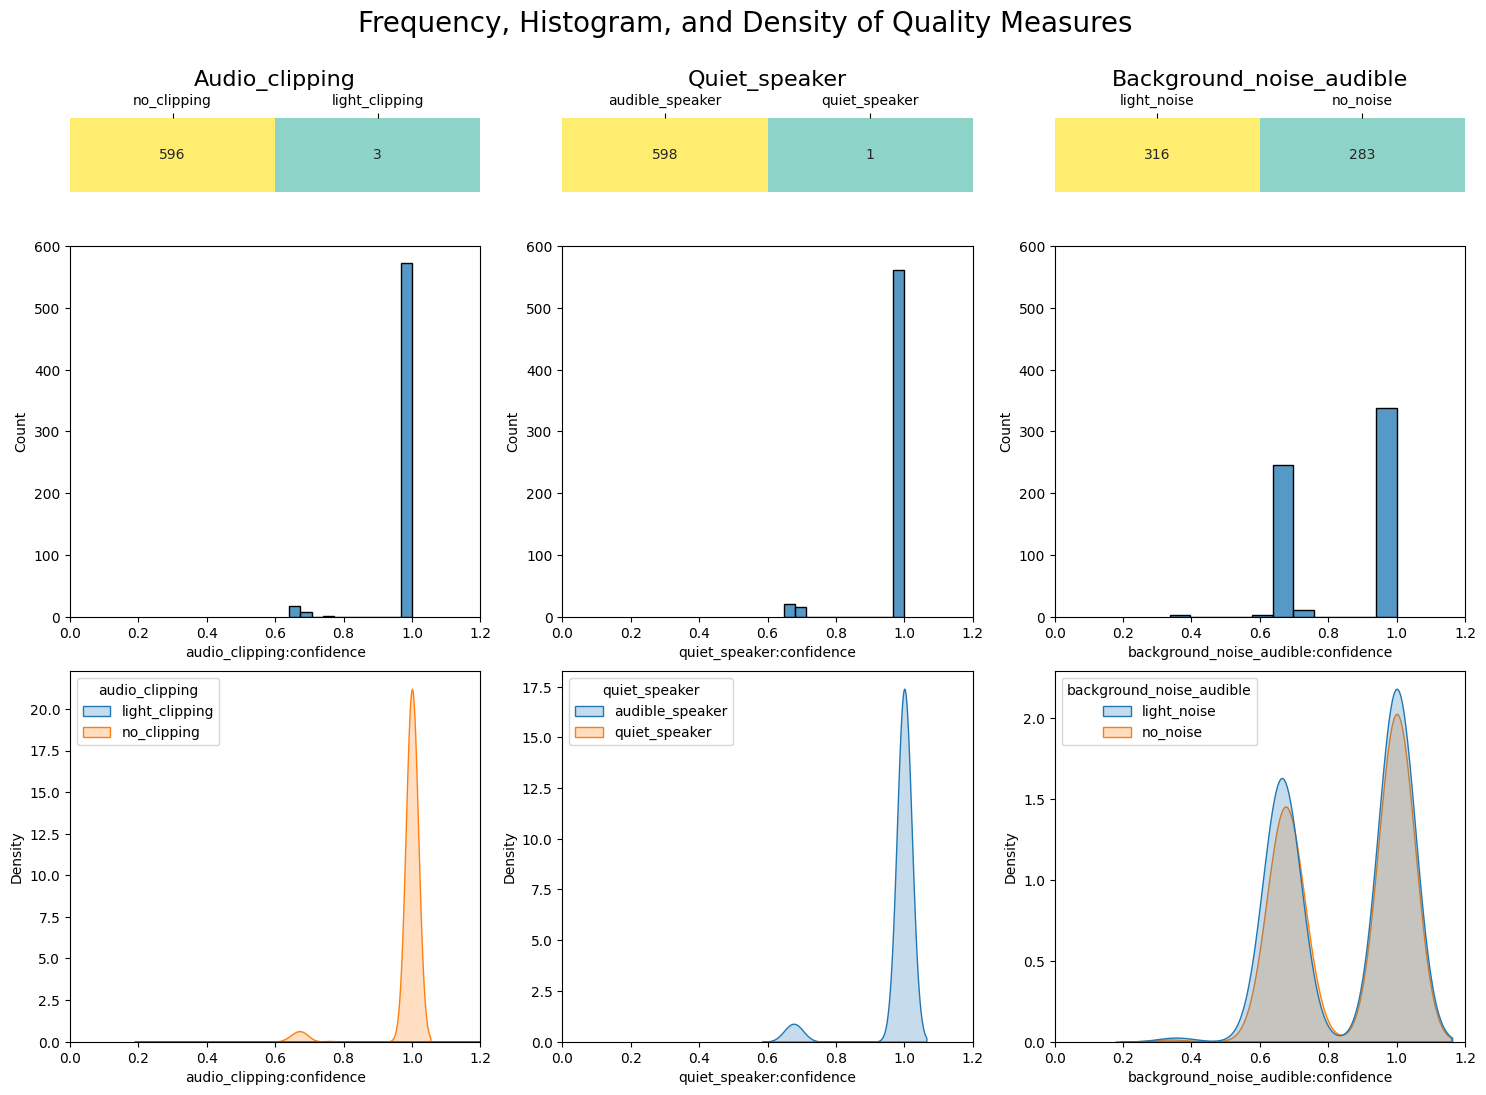

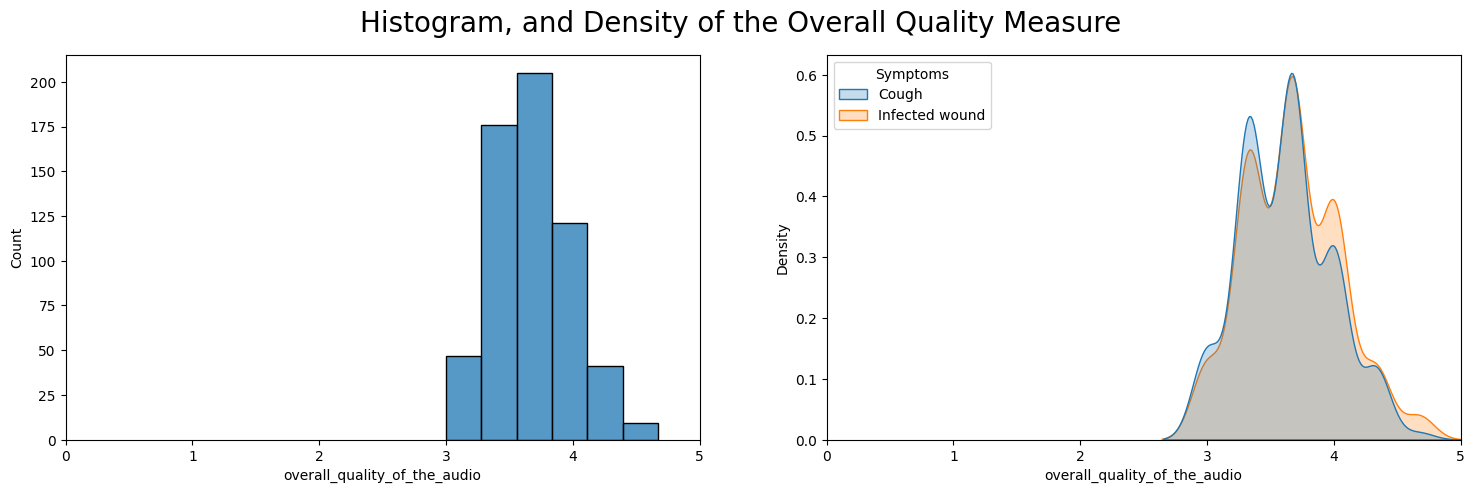

In [7]:
EDA_analysis.EDA_quality_measures()

We can see somewhat of a normality in the distribution of the feature, we will check the correlation of all the quality measures

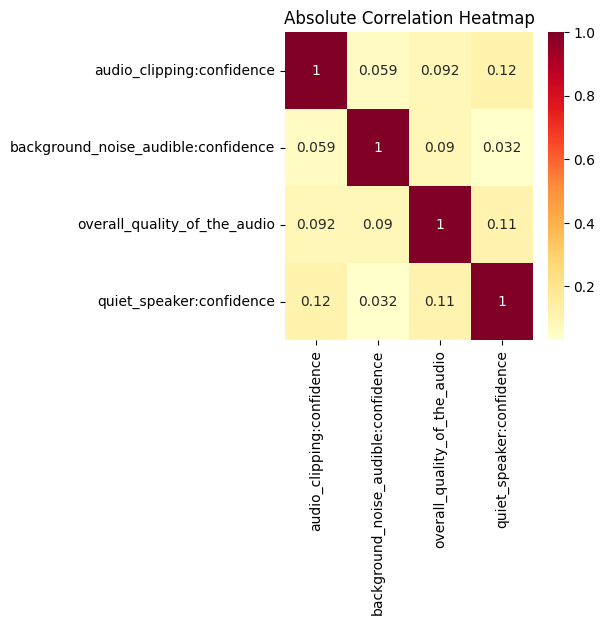

In [8]:
EDA_analysis.Correlation_Matrix()

---
## **Personal Audio Measures**
In this subsection I will delve into the personal audio measures which are:

* $\underline{Writer~ID}$: The person's unique ID which wrote the pharse said by the speaker.

* $\underline{Speaker~ID}$: The person's unique ID which was recored in the audio file.


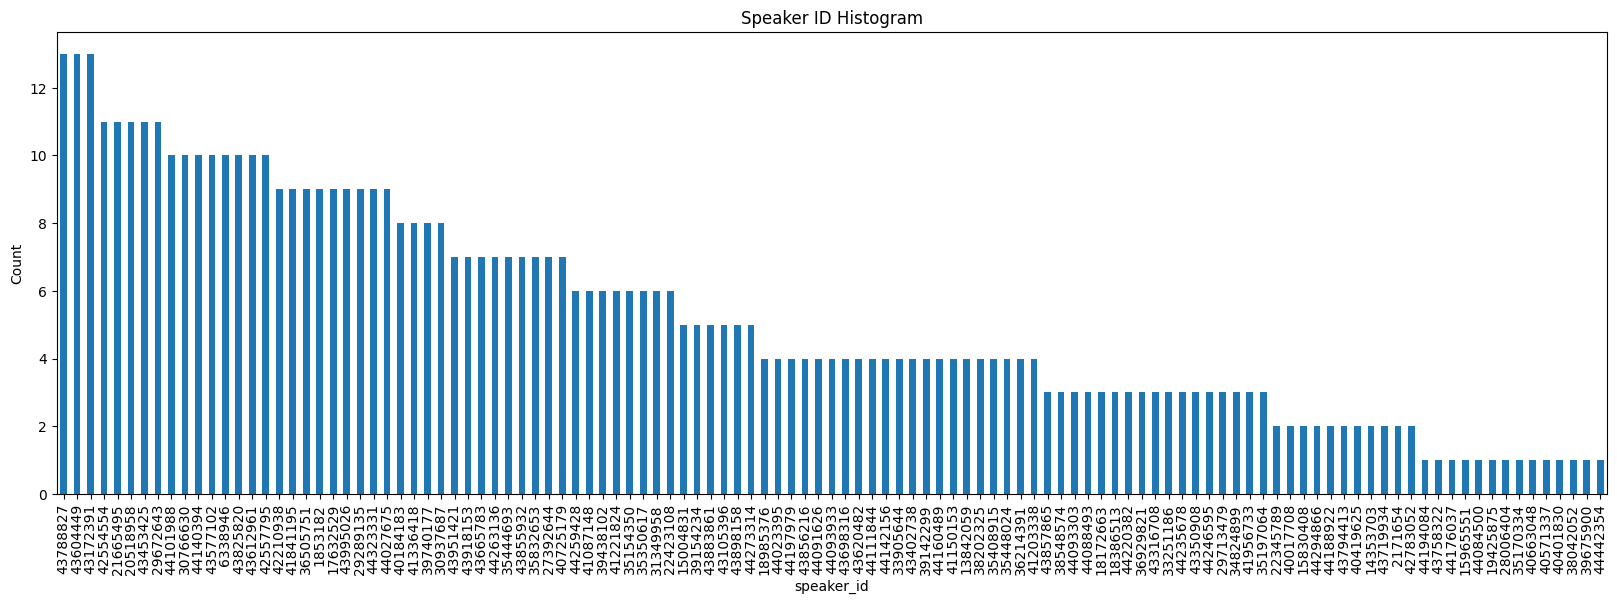

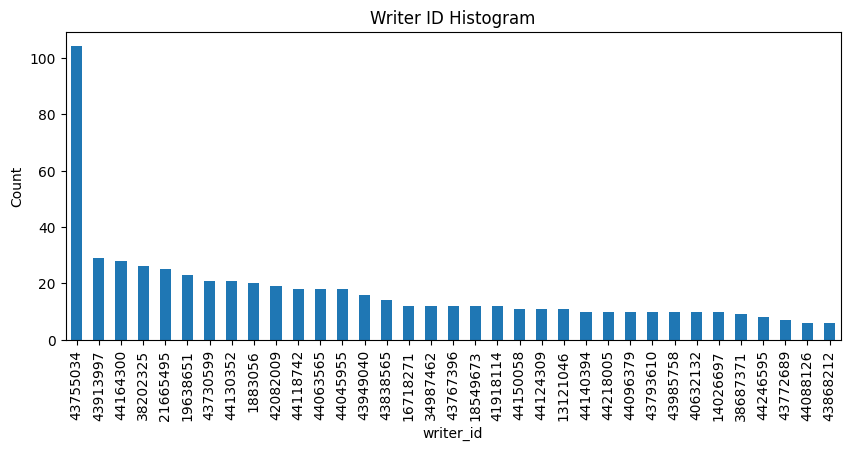

In [9]:
EDA_analysis.EDA_writers_speakers()

---
## **Symptom**
The label

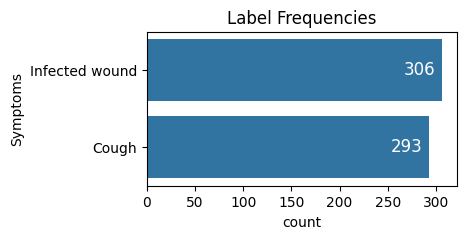

In [10]:
EDA_analysis.EDA_symptoms()

---
## **Audio Recordings**

In [11]:
EDA_analysis.Add_audio_features(inplace = True)

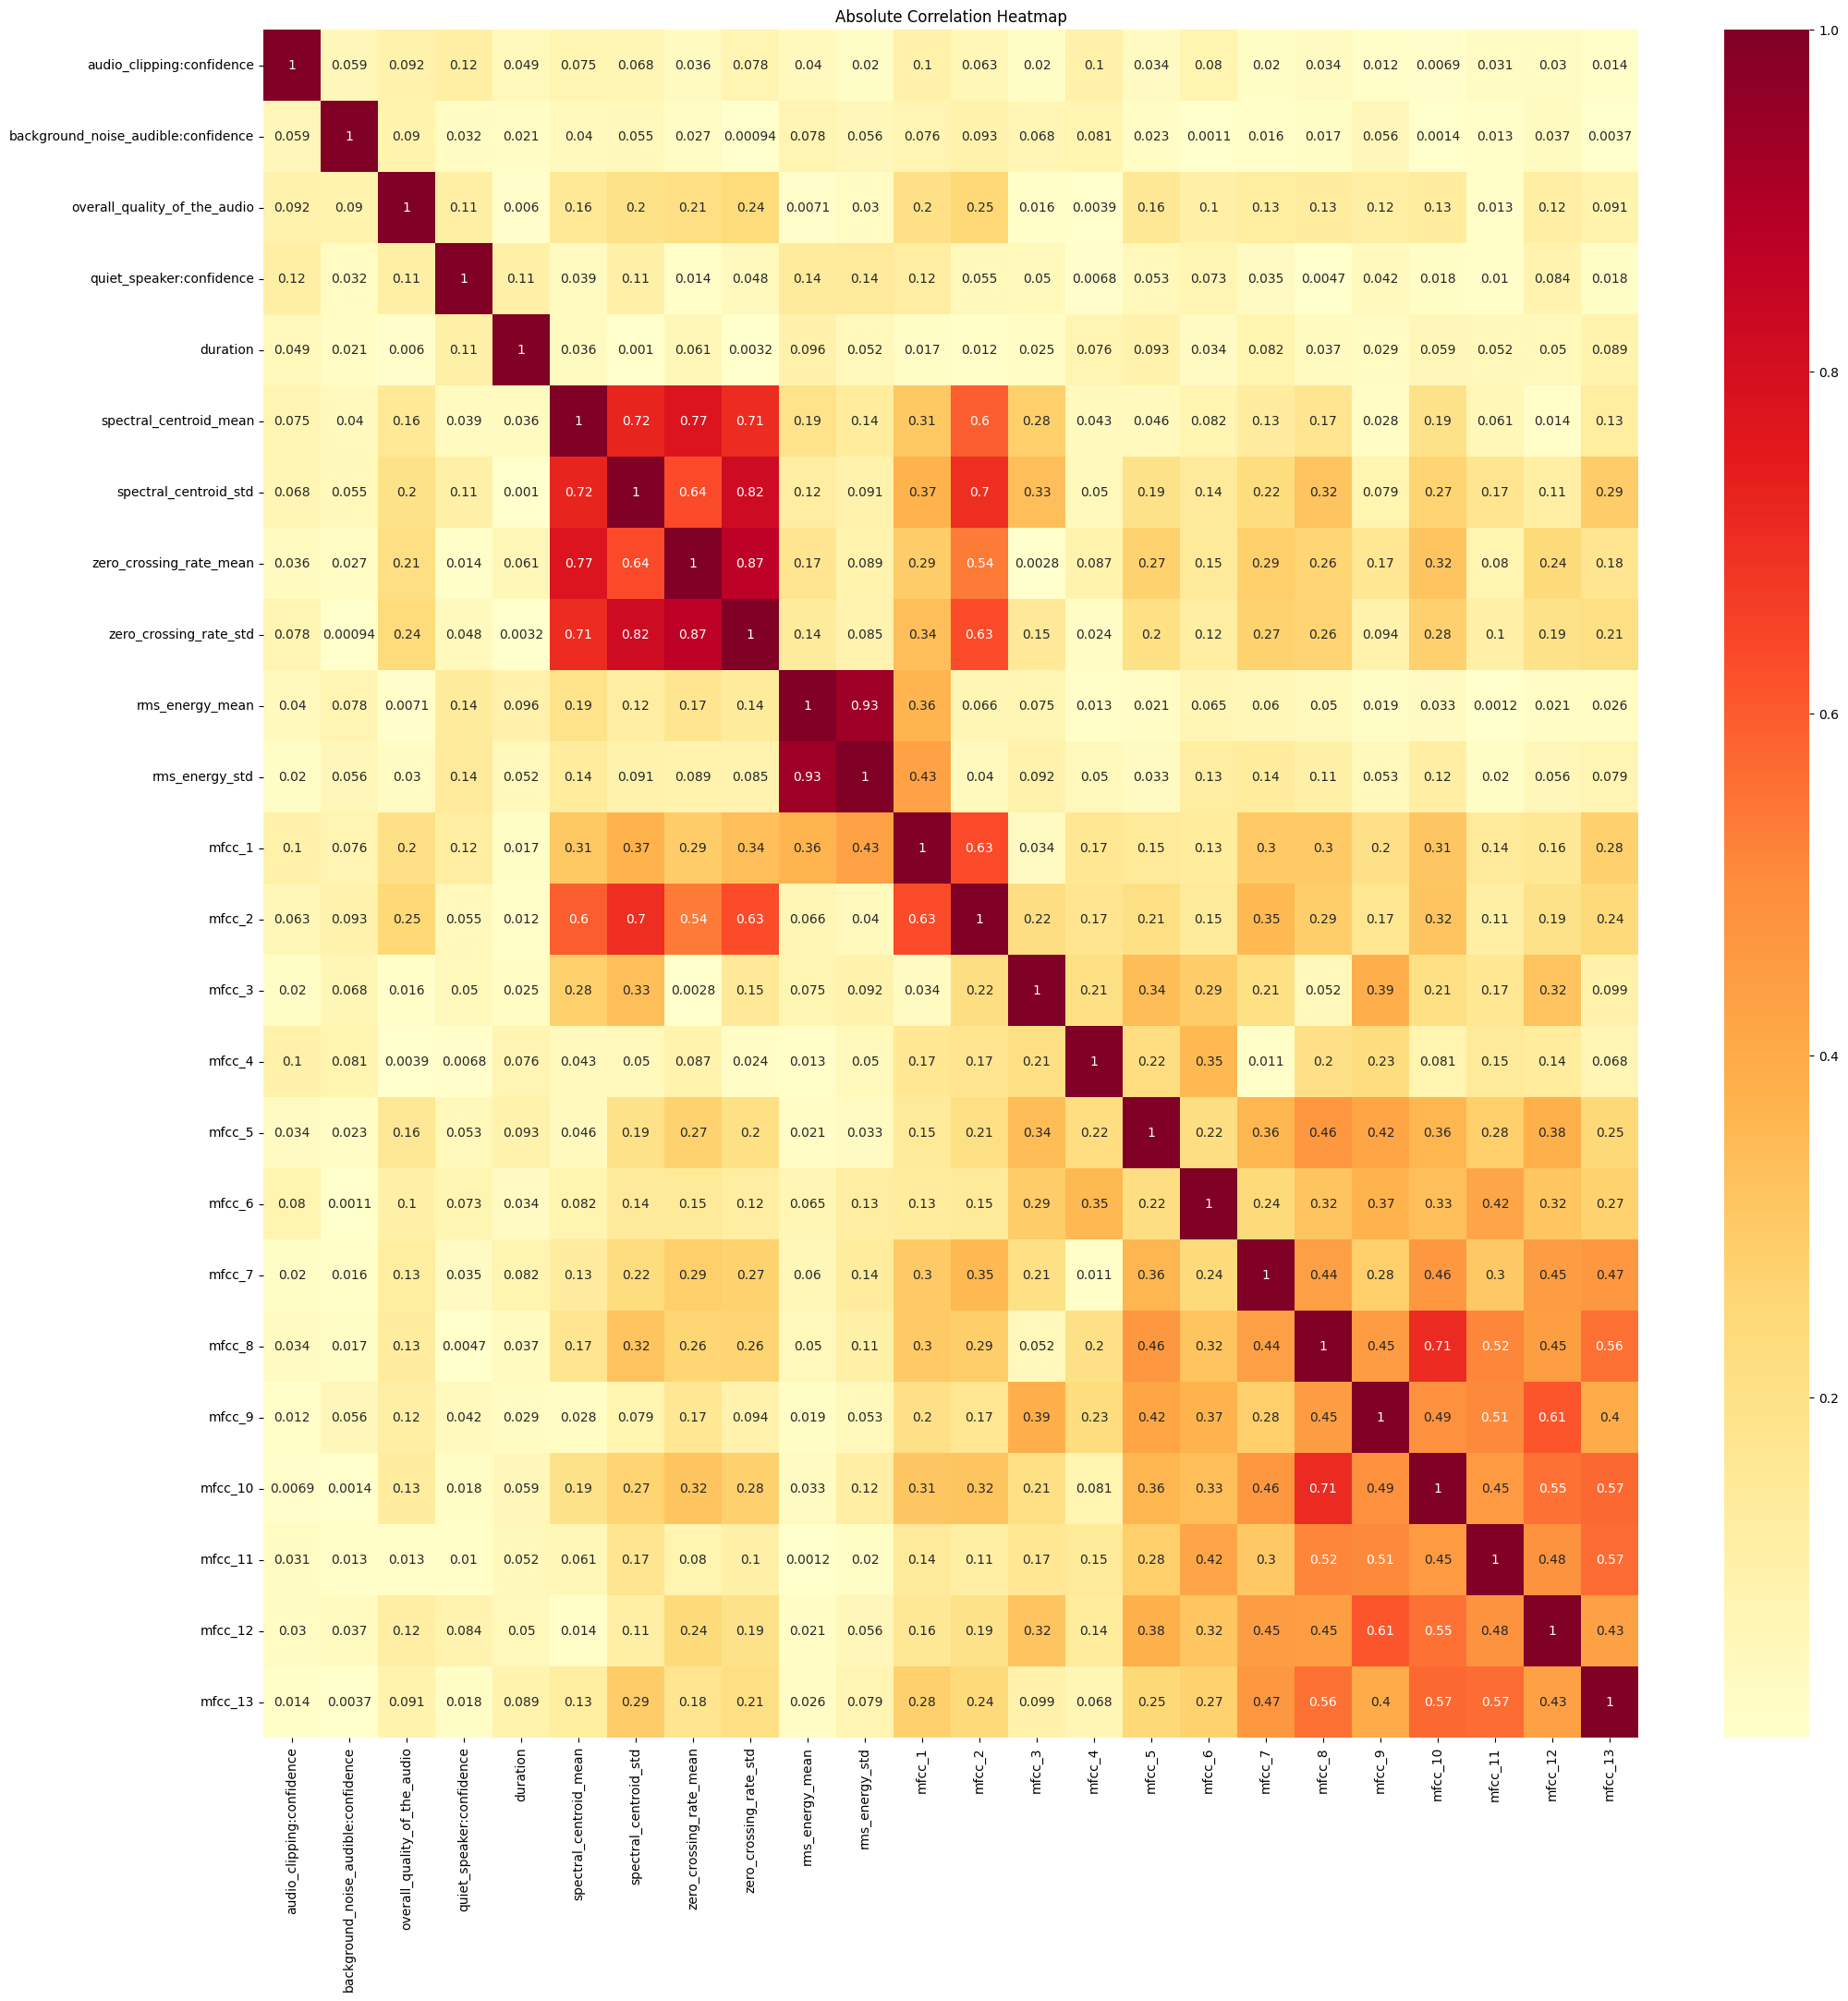

In [12]:
EDA_analysis.Correlation_Matrix()

## **Clustering**

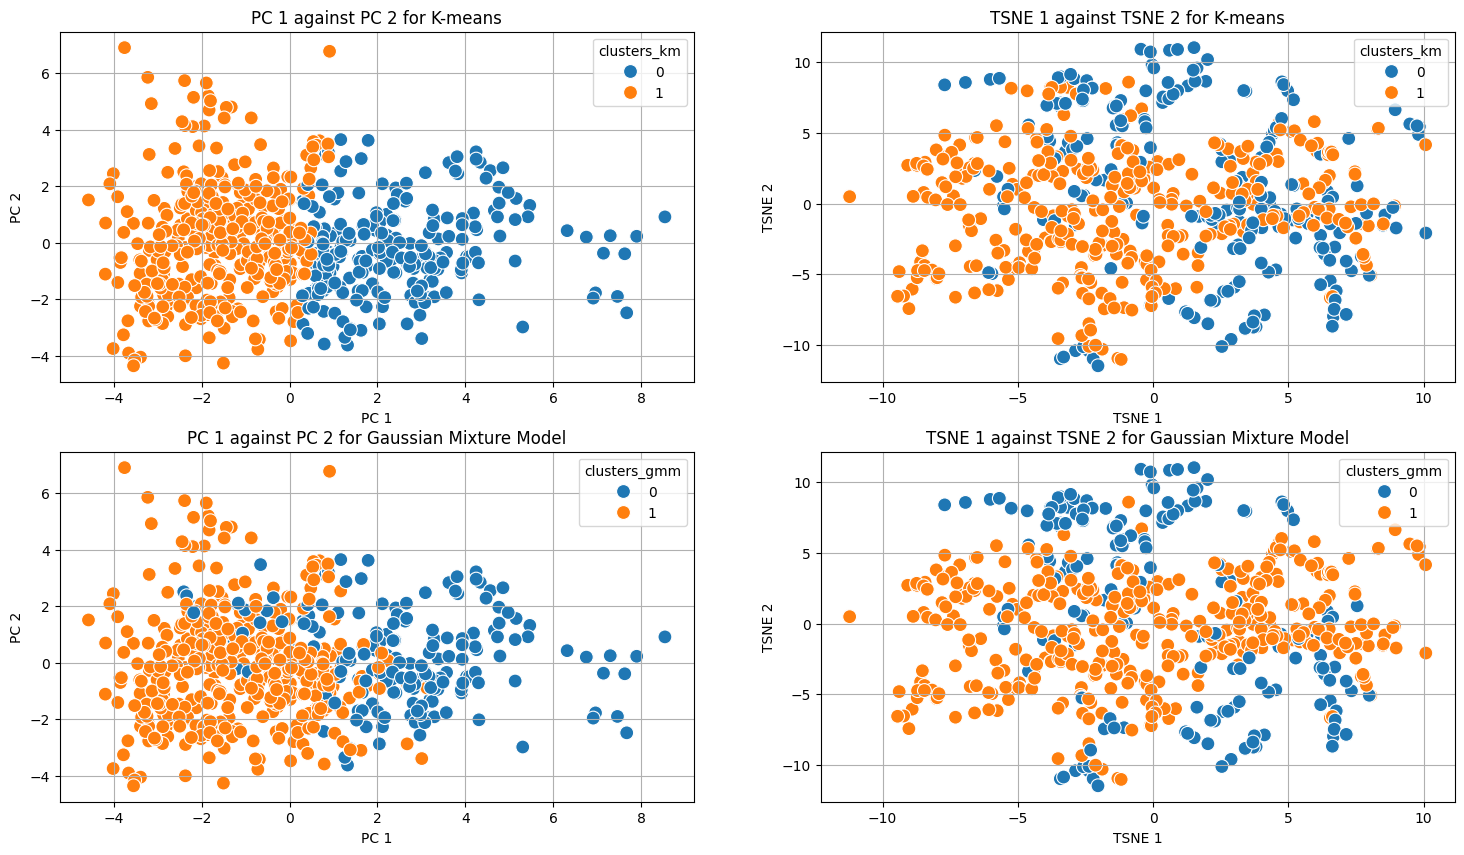

In [13]:
EDA_analysis.Clustering(inplace = True)
X, y = EDA_analysis.X, EDA_analysis.y

---
# **Feature Engineering** - To Delete

I will combine the quality measures value and confidence into one column, for example:

$$
new~audio~clipping_i=confidence_i\times(-1)^{\mathbb{I}(audio~clipping_i="light~clipping")}
$$

So now, for the quality measure we have one feature in range $[-1,1]$, where values around $0$ means bad confidence in quality measure and around the edges $\{-1,1\}$ means good confidence in quality measure.

In [ ]:
#dat['audio_clipping_new'] = dat['audio_clipping'].map({'no_clipping': 1, 'light_clipping': -1}).astype(int) * dat['audio_clipping:confidence']
#dat['background_noise_audible_new'] = dat['background_noise_audible'].map({'no_noise': 1, 'light_noise': -1}).astype(int) * dat['background_noise_audible:confidence']
#dat['quiet_speaker_new'] = dat['quiet_speaker'].map({'audible_speaker': 1, 'quiet_speaker': -1}).astype(int) * dat['quiet_speaker:confidence']
#new_quantitive_dat = dat[['audio_clipping_new','background_noise_audible_new','quiet_speaker_new','overall_quality_of_the_audio']]
#sns.heatmap(new_quantitive_dat.corr(), cmap='YlOrRd', annot=True)

In [ ]:
#final_dat = dat[['audio_clipping_new','background_noise_audible_new','quiet_speaker_new','overall_quality_of_the_audio','duration','prompt']]

Now we need to split the data to train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

Now we need to scale the data

In [ ]:
scaler = StandardScaler().fit(x_train) # training the scaler model using the train set!
x_train_scaled = scaler.transform(x_train) # scaling the train set
x_test_scaled = scaler.transform(x_test) # scaling the train set

array([[ 0.45330011, -0.15391222, -0.99058777, ..., -3.90530525,
        -0.07298025,  0.        ],
       [-2.43350477,  0.59913537, -1.48606712, ...,  0.24960839,
        -0.07298025,  0.        ],
       [-1.81311103,  0.39546549,  0.39866638, ...,  0.24960839,
        -0.9853262 ,  0.        ],
       ...,
       [ 0.151033  , -0.07415446, -0.62514517, ...,  0.24960839,
         1.69804425,  0.        ],
       [ 0.51871711, -1.23949902,  0.32253222, ...,  0.24960839,
        -0.07298025,  0.        ],
       [ 1.16461516,  1.16501941, -0.12220788, ...,  0.24960839,
        -0.9853262 ,  0.        ]])

# **Training the Models** - To Delete

In [ ]:
def print_cm(gridsearchCV, X_train, X_test, y_train, y_test):

  test_pred = gridsearchCV.best_estimator_.predict(X_test)
  train_acc = round(np.mean(gridsearchCV.best_estimator_.predict(X_train) == y_train),3)
  test_acc = round(np.mean(test_pred == y_test),3)
  # Plot confusion matrix
  classes = np.unique(y_test)
  cm = confusion_matrix(y_test, test_pred)

  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()
  # Calculate sensitivity and specificity for each class
  num_classes = len(cm)
  sensitivity = []
  specificity = []
  accuracy = []
  f2_score = []

  #class_names = np.array(list(set(y_test)))
  for class_idx in range(num_classes):
    TP = cm[class_idx, class_idx]
    FN = np.sum(cm[class_idx, :]) - TP
    FP = np.sum(cm[:, class_idx]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sensitivity.append(round(TP / (TP + FN),3))
    specificity.append(round(TN / (TN + FP),3))
    accuracy.append(round((TP + TN) / np.sum(cm),3))
    f2_score.append(round(2 * (sensitivity[-1] * specificity[-1]) / (sensitivity[-1] + specificity[-1]),3))

  # Create a DataFrame from the lists
  df = pd.DataFrame({'Class': classes, 'Accuracy': accuracy , 'Sensitivity': sensitivity, 'Specificity': specificity, 'F2':f2_score})

  # Melt the DataFrame to combine Sensitivity and Specificity into a single column
  df_melted = df.melt('Class', var_name='Metric', value_name='Value')

  # Plot the bar plot
  ax = sns.barplot(x='Class', y='Value', hue='Metric', data=df_melted)

  # Annotate the bars with their values
  for i in ax.containers:
    ax.bar_label(i,)

  # Set the plot title and labels
  plt.title('Test Set Evlauation Metrics by Symptom')
  plt.xlabel('Medical Symptom')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

  return train_acc, test_acc, classes, sensitivity, specificity

In [ ]:
log_reg = LogisticRegression(random_state=1, solver = 'saga', max_iter = 1000)  # max_iter = 1000 - for improving convergence
                                                                                # For logistic regression with regularization one must choose 'saga' solver

parameters = {'penalty':['l1'], # L1 penalty = Lasso, L2 penalty = Ridge
              'C': np.exp(np.arange(0,3,0.05))} # small C values means stronger regularization and the opposite

log_reg_cv = GridSearchCV(log_reg, parameters, cv=10, n_jobs=-1, scoring='accuracy',verbose=10).fit(x_train_scaled, y_train)
best_log=log_reg_cv.best_estimator_
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_log.coef_[0]})
coefficients_df.iloc[coefficients_df['Coefficient'].abs().sort_values(ascending=False).index]

,Feature,Coefficient
32,rms_energy_std,-1.402248
26,duration,1.184216
31,rms_energy_mean,1.181295
17,mfcc_std_5,-1.150532
22,mfcc_std_10,0.525950
29,zero_crossing_rate_mean,-0.429202
6,mfcc_mean_7,-0.382341
24,mfcc_std_12,0.362210
15,mfcc_std_3,0.339526
10,mfcc_mean_11,-0.325660


In [ ]:
log_reg = LogisticRegression(random_state=1, solver = 'saga', max_iter = 1000)  # max_iter = 1000 - for improving convergence
                                                                                # For logistic regression with regularization one must choose 'saga' solver

parameters = {'penalty':['l1','l2'], # L1 penalty = Lasso, L2 penalty = Ridge
              'C': np.exp(np.arange(0,3,0.05))} # small C values means stronger regularization and the opposite

log_start = time()
log_reg_cv = GridSearchCV(log_reg, parameters, cv=10, n_jobs=-1, scoring='accuracy',verbose=10).fit(x_train_scaled, y_train)
log_end = time()

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


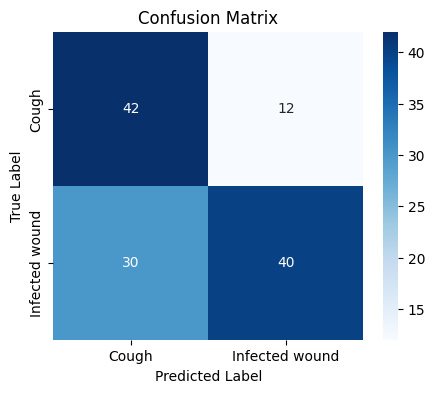

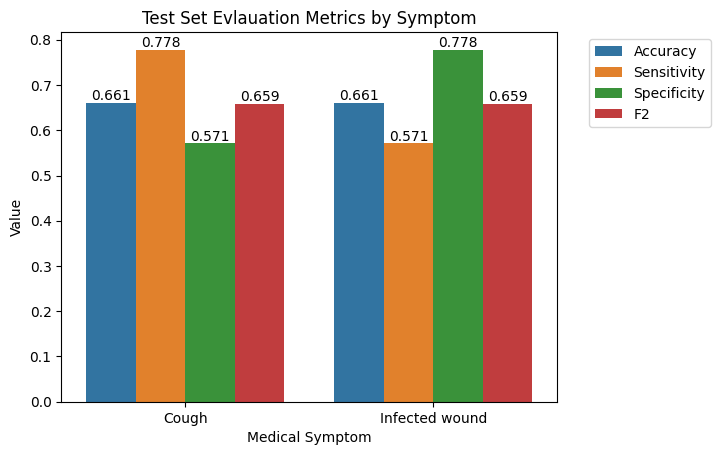

In [ ]:
log_train_acc, log_test_acc, classes, log_sensitivity, log_specificity = print_cm(log_reg_cv, x_train_scaled, x_test_scaled, y_train, y_test)

Logistic Regression running time = 0.709 minutes
Lasso best parameters: {'C': 1.0, 'penalty': 'l1'}
Lasso Train Accuracy: 0.713
Lasso Test Accuracy: 0.661


<Axes: xlabel='row_0', ylabel='prompt'>

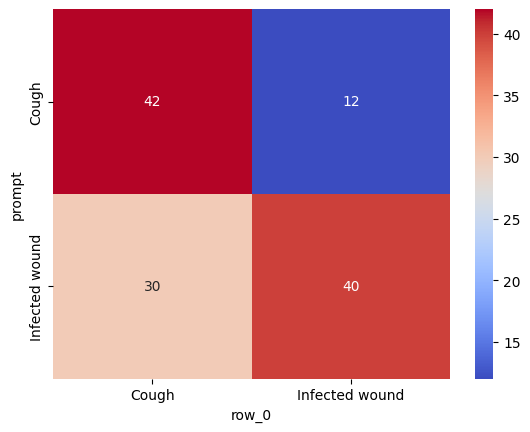

In [ ]:
print(f'Logistic Regression running time = {round((log_end-log_start)/60,3)} minutes')
print(f'Lasso best parameters: {log_reg_cv.best_params_}')
print(f'Lasso Train Accuracy: {round(np.mean(log_reg_cv.predict(x_train_scaled) == y_train),3)}')
print(f'Lasso Test Accuracy: {round(np.mean(log_reg_cv.predict(x_test_scaled) == y_test),3)}')
#plt.figure(figsize=(6, 10))
sns.heatmap(pd.crosstab(log_reg_cv.predict(x_test_scaled), y_test).T, cmap='coolwarm', annot=True)

In [ ]:
KNN = KNeighborsClassifier()

start = time()
knn_cv = GridSearchCV(KNN, param_grid={'n_neighbors': range(3, 124, 2)}, cv = 10, n_jobs=-1, verbose=10).fit(x_train_scaled, y_train)
stop = time()

Fitting 10 folds for each of 61 candidates, totalling 610 fits


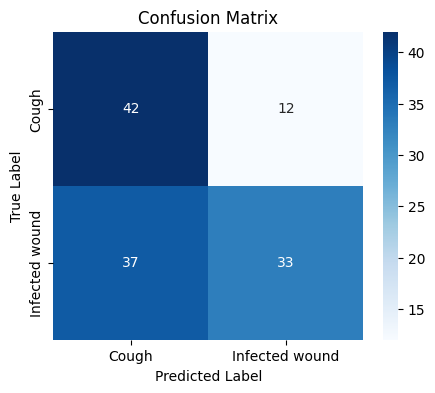

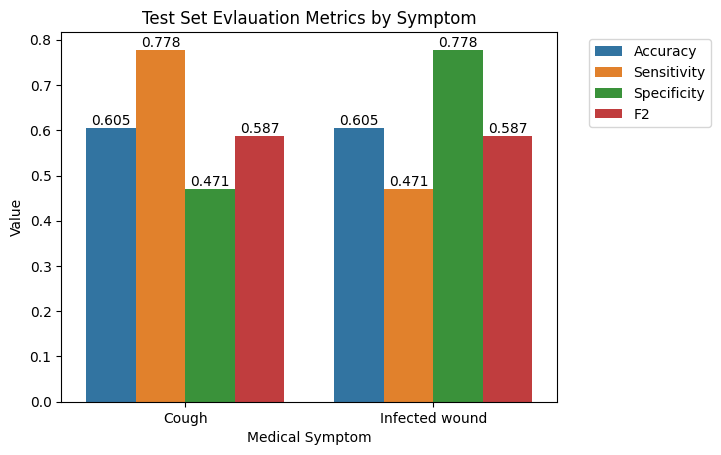

In [ ]:
knn_train_acc, knn_test_acc, classes, knn_sensitivity, knn_specificity = print_cm(knn_cv, x_train_scaled, x_test_scaled, y_train, y_test)

KNN running time 0.117 in minutes
KNN best parameters: {'n_neighbors': 47}
KNN Train Accuracy: 0.699
KNN Test Accuracy: 0.605


<Axes: xlabel='row_0', ylabel='prompt'>

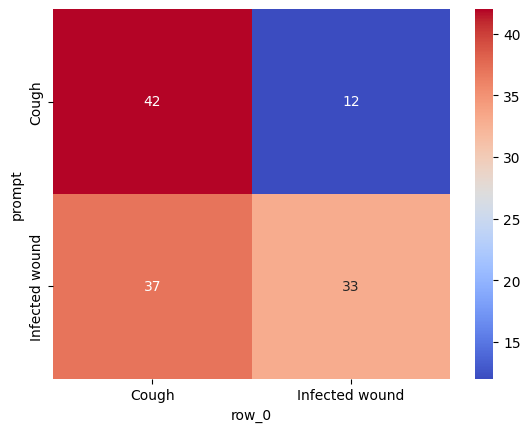

In [ ]:
print(f'KNN running time {round((stop-start)/60,3)} in minutes')
print(f'KNN best parameters: {knn_cv.best_params_}')
print(f'KNN Train Accuracy: {round(np.mean(knn_cv.predict(x_train_scaled) == y_train),3)}')
print(f'KNN Test Accuracy: {round(np.mean(knn_cv.predict(x_test_scaled) == y_test),3)}')

sns.heatmap(pd.crosstab(knn_cv.predict(x_test_scaled), y_test).T, cmap='coolwarm', annot=True)

In [ ]:
svm = SVC(probability=True, max_iter = 500, random_state=1)
parameters = {'C': np.arange(1.2,2,0.4),
              'kernel': ['linear', 'poly', 'rbf'],
              'degree': np.arange(2,6,1),
              'gamma': 10**np.arange(-4, 0, 1, dtype=np.float64)}

start = time()
svm_cv = GridSearchCV(svm, param_grid=parameters, cv=5, n_jobs=-1, verbose=3).fit(x_train_scaled, y_train)
stop = time()

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
print(f'SVM running time {round((stop-start)/60,3)} in minutes')
print(f'SVM best parameters: {svm_cv.best_params_}') # gamma is irelevant for poly kernel
print(f'SVM Train Accuracy: {round(np.mean(svm_cv.predict(x_train_scaled) == y_train),3)}')
print(f'SVM Test Accuracy: {round(np.mean(svm_cv.predict(x_test_scaled) == y_test),3)}')
pd.crosstab(svm_cv.best_estimator_.predict(x_test_scaled), y_test, margins=True)

SVM running time 0.18 in minutes
SVM best parameters: {'C': 1.2, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Train Accuracy: 0.747
SVM Test Accuracy: 0.661


prompt,Cough,Infected wound,All
row_0,,,
Cough,48,36,84
Infected wound,6,34,40
All,54,70,124


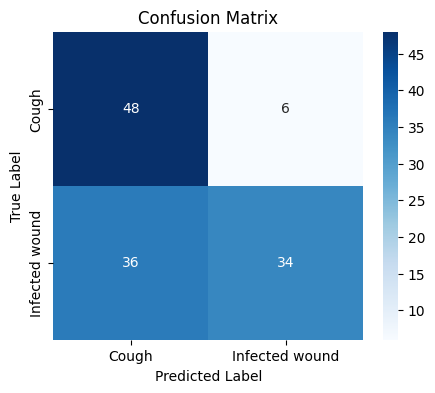

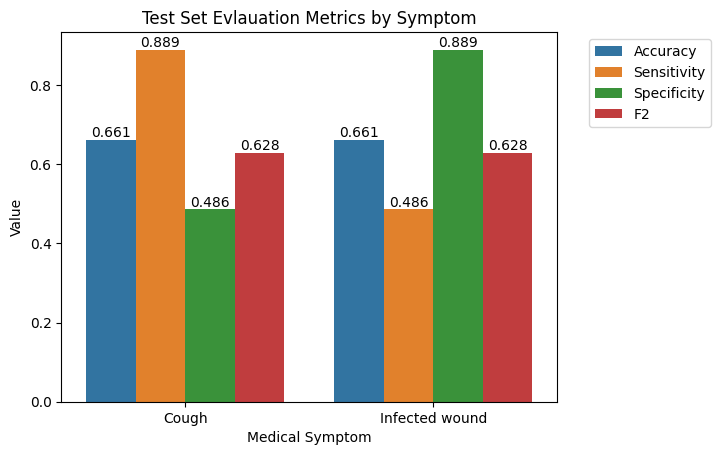

In [ ]:
svm_train_acc, svm_test_acc, classes, svm_sensitivity, svm_specificity = print_cm(svm_cv, x_train_scaled, x_test_scaled, y_train, y_test)

In [ ]:
C_tree = tree.DecisionTreeClassifier(random_state=1)
parameters = {'max_depth': [6,7,8],
              'min_samples_split': [2,3,4],
              'min_samples_leaf': [9,10,11],
              'criterion': ['gini'],
              'max_features': [23,24,25]}

start = time()
classification_tree_cv = GridSearchCV(C_tree, parameters, cv=10, n_jobs=-1, verbose=3).fit(x_train, y_train)
stop = time()

Fitting 10 folds for each of 81 candidates, totalling 810 fits


In [ ]:
classification_tree_cv.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 24,
 'min_samples_leaf': 11,
 'min_samples_split': 2}

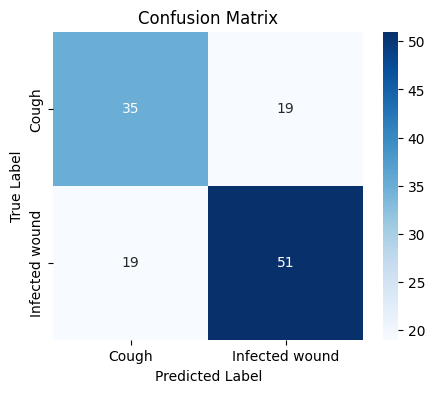

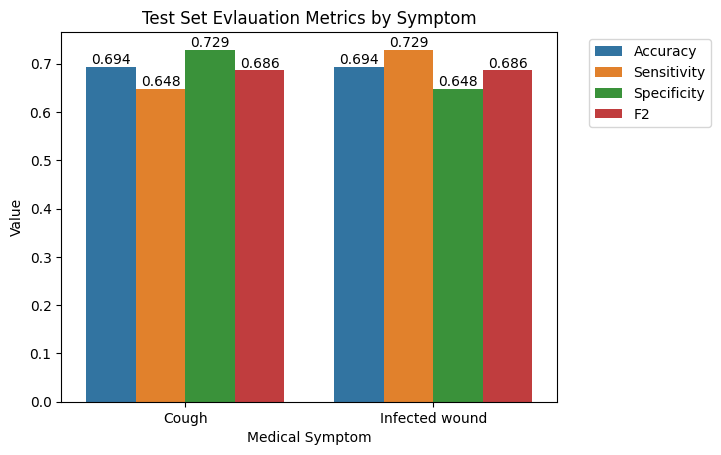

In [ ]:
C_train_acc, C_test_acc, classes, C_sensitivity, C_specificity = print_cm(classification_tree_cv, x_train, x_test, y_train, y_test)

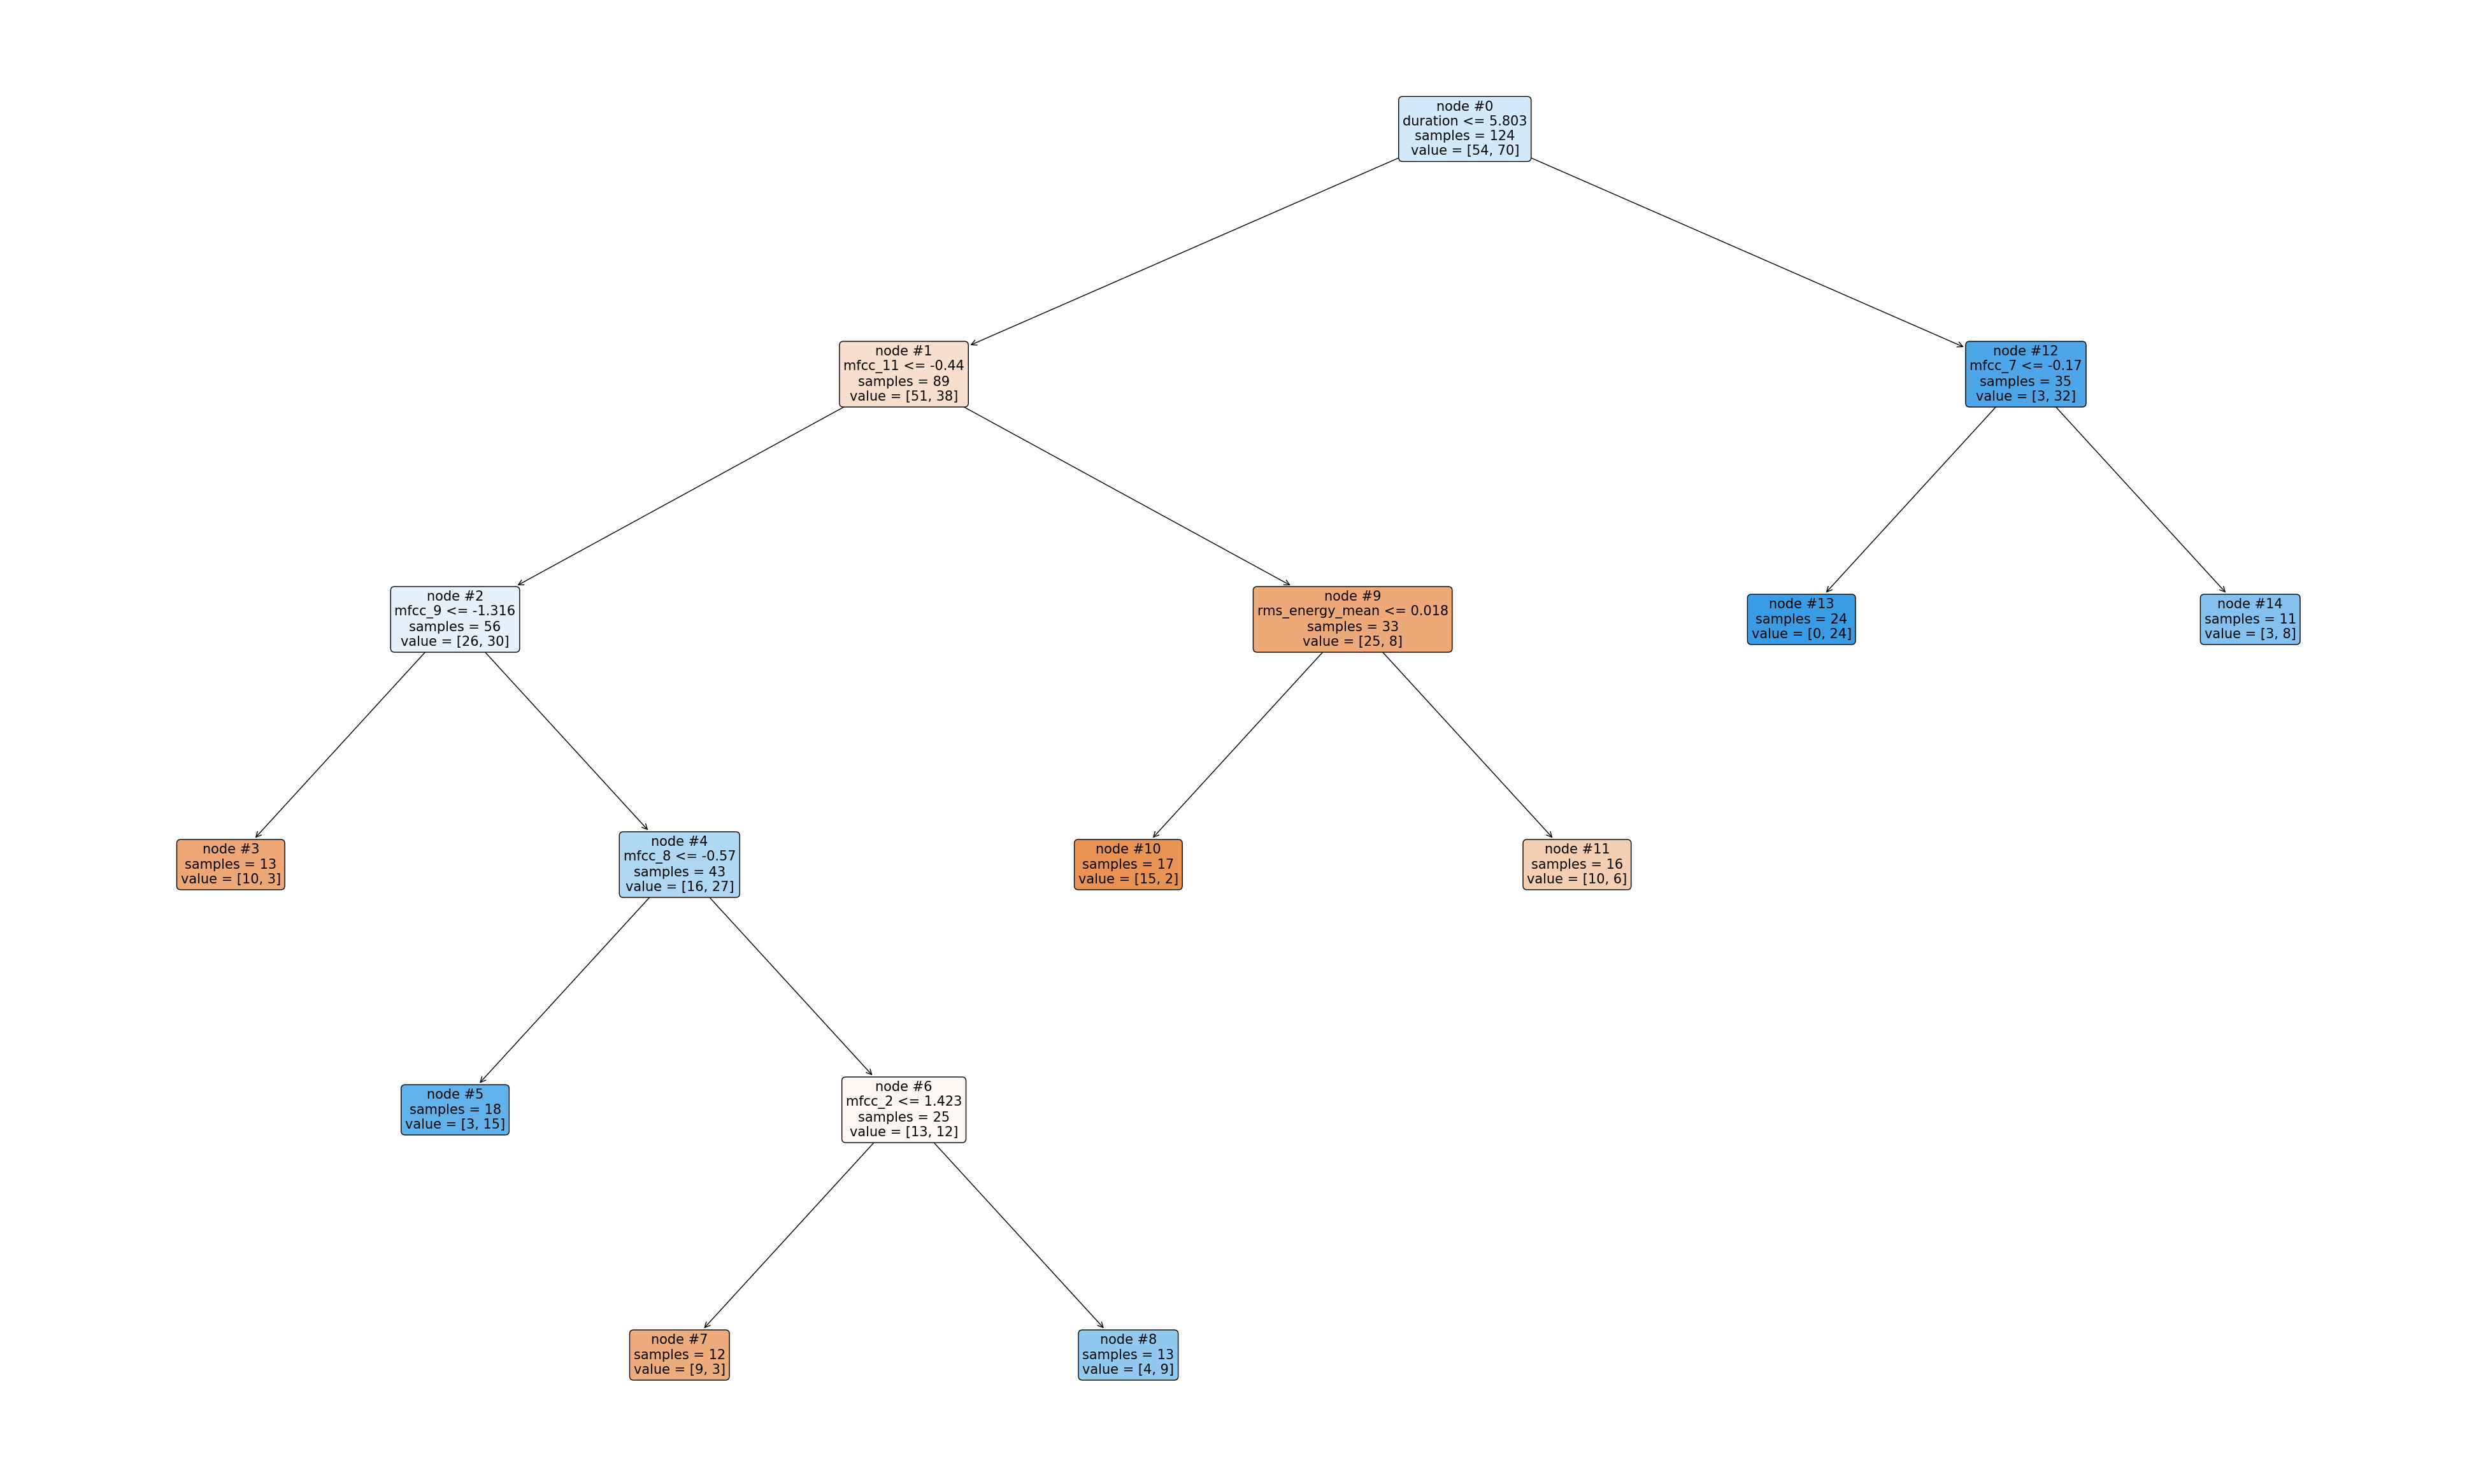

In [ ]:
plt.figure(figsize=(50,30))
tree.plot_tree(classification_tree_cv.best_estimator_.fit(x_test, y_test), fontsize=15, filled=True, feature_names=X.columns,
               impurity=False, node_ids=True, rounded=True)
plt.show()

# **Libraries Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from IPython.display import display, Latex

# **Modeling Section**
In this section I've created a modeling object which all the neccesary variables and methods in order to preform the modeling procedures.

The following models were selected with gridsearch cross-validation with the following parameter grids are:
* <u>**Logistic Regression**</u>

  `Penalty`: LASSO (L1) or Ridge (L2).

  `C`: $∈[e^−1, 1]$ - penalty inverse parameter, as it is smaller the stronger the regularization.

* <u>**K-Nearest Neighbors**</u>

  `K`: number of nearest neighbors $∈ [3, m]$ in odds numbers. Where, $m$ is the number of observations in the test set.

* <u>**Support Vector Machine**</u>

  `kernel`: Linear, Polynomial, or Radial.
  
  `C`: $∈[e^−1, 1]$ - penalty inverse parameter, as it is smaller the stronger the regularization.

  `degree`: $∈[3, 6]$ for the polynomial kernel.

  `gamma`: $∈\{0.001, 0.01, 0.1, 1\}$ for the radial kernel.

* <u>**Classification Tree**</u>

  `Maximal Depth`: $∈[3, 7]$ - the maximal depth of the tree.
  `Minimum Samples in Leaf`: $∈[5, 8]$ - the minimum observations in a leaf node.

  `Criterion`: Gini or Entropy.


---
The object attributes and functions are:

$\underline{Attributes}:$

    X : pd.DataFrame or np.ndarray
Features used for training and testing the model.

    y : pd.Series or np.ndarray
Target values used for training and testing the model.

    NLP : bool, optional
Flag indicating whether the data is related to Natural Language Processing (default is False).

    X_train : np.ndarray
Training set features after splitting and scaling.

    X_test : np.ndarray
Test set features after splitting and scaling.

    X_train_unscaled : np.ndarray
Training set features before scaling.

    X_test_unscaled : np.ndarray
Test set features before scaling.

    y_train : np.ndarray
Training set target values after splitting.

    y_test : np.ndarray
Test set target values after splitting.

    best_model : dict
Dictionary storing the best models for different algorithms.

    best_params : dict
Dictionary storing the best parameters for different algorithms.

    predictions : dict
Dictionary storing the predictions made by different algorithms.

---
$\underline{Methods}:$

    split_scale_data(random_state=1, test_size=0.3):
Splits the data into training and test sets and scales the features.

    train_models(random_state=1, cv=5):
Trains various machine learning models using Grid Search with Cross-Validation to find the best parameters.

    test_models():
Tests the trained models on the test set and stores the predictions.

    plot_tree():
Plots the decision tree model, if applicable.

    results(show_df=False, show_df_in_latex=False, show_cm=False, show_eval=False):
Displays the results of the model evaluations including metrics and confusion matrices.

---

In [ ]:
class modelingObject:
  def __init__(self, X, y, NLP = False):
    self.X = X
    if type(y) == pd.core.series.Series:
      self.y = y.values
    else:
      self.y = y
    self.NLP = NLP
    self.X_train = None
    self.X_test = None
    self.X_train_unscaled = None
    self.X_test_unscaled = None
    self.y_train = None
    self.y_test = None
    self.best_model = {}
    self.best_params = {}
    self.predictions = {}

  def split_scale_data(self, random_state=1, test_size=0.3):
    # Execptions
    if self.X is None or (type(self.X) != pd.core.frame.DataFrame and type(self.X) != np.ndarray):
      raise ValueError("X must be a pandas DataFrame or numpy array")
    if self.y is None or (type(self.y) != pd.core.series.Series and type(self.y) != np.ndarray):
      raise ValueError("y must be a pandas Series or numpy array")
    if len(self.y.shape) != 1 :
      raise ValueError("y must have only one column")
    if self.X.shape[0] != self.y.shape[0]:
      raise ValueError("X and y must have the same number of rows")
    if self.X.shape[0] < 2 or y.shape[0] < 2:
      raise ValueError("X and y must have at least 2 rows")

    # Split the data into train and test sets and scale it
    print("Splitting and scaling the data")
    print("-----------------------------------")
    if self.X_train is None:
      self.X_train_unscaled, self.X_test_unscaled, self.y_train, self. y_test = train_test_split(self.X, self.y, random_state=random_state, test_size=test_size)
      scaler = StandardScaler().fit(self.X_train_unscaled)
      self.X_train = scaler.transform(self.X_train_unscaled)
      self.X_test = scaler.transform(self.X_test_unscaled)


  def train_models(self, random_state=1, cv=5):
    # Exceptions
    if self.X_train is None:
      self.split_scale_data(random_state = random_state)

    # Initialization of the models
    init_LR = LogisticRegression(random_state=random_state, solver = 'saga')  # For logistic regression with regularization one must choose 'saga' solver
    if not self.NLP:
      init_KNN = KNeighborsClassifier()
      init_SVM = SVC(random_state=random_state, probability=True)
      init_DT = DecisionTreeClassifier(random_state=random_state)

    # Setting grid search parameter grids'
    parameters_LR = {'penalty':['l1','l2'], # L1 penalty = Lasso, L2 penalty = Ridge
                      'C': np.exp(np.arange(-1,0,0.05))} # small C values means stronger regularization and the opposite
    if not self.NLP:
      parameters_KNN = {'n_neighbors': range(3, self.X_test.shape[0], 2)}
      parameters_SVM = {'C': np.exp(np.arange(-1,0,0.1)),
                        'kernel': ['linear', 'poly', 'rbf'],
                        'degree': np.arange(3,6,1),
                        'gamma': 10**np.arange(-4, 0, 1, dtype=np.float64)}
      parameters_DT = {'max_depth': np.arange(3,7,1),
                        'min_samples_leaf': np.arange(5,8,1),
                        'criterion': ['gini','entropy']}

    # Cross validation and finding the most 'accurate' model for each set of parameters
    print("Training Phase:")
    print("Training \'Logistic Regression\' model")
    GSCV = GridSearchCV(init_LR, parameters_LR, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3).fit(self.X_train, self.y_train)
    self.best_model["Logistic Regression"] = GSCV.best_estimator_
    self.best_params["Logistic Regression"] = GSCV.best_params_
    if not self.NLP:
      print("Training \'K-Nearest Neighbors\' model")
      GSCV = GridSearchCV(init_KNN, parameters_KNN, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3).fit(self.X_train, self.y_train)
      self.best_model["K-Nearest Neighbors"] = GSCV.best_estimator_
      self.best_params["K-Nearest Neighbors"] = GSCV.best_params_
      print("Training \'Support Vector Machine\' model")
      GSCV = GridSearchCV(init_SVM, parameters_SVM, cv=cv, n_jobs=-1, verbose=3).fit(self.X_train, self.y_train)
      self.best_model["Support Vector Machine"] = GSCV.best_estimator_
      self.best_params["Support Vector Machine"] = GSCV.best_params_
      print("Training \'Decision Tree\' model")
      GSCV = GridSearchCV(init_DT, parameters_DT, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3).fit(self.X_train_unscaled, self.y_train)
      self.best_model["Decision Tree"] = GSCV.best_estimator_
      self.best_params["Decision Tree"] = GSCV.best_params_
    print("The training of the models is done.")
    print("-----------------------------------")

  def test_models(self):
    # Exceptions
    if not self.best_model:
      self.train_models()

    # Testing the models
    print("Testing Phase:")
    print("Testing \'Logistic Regression\' model")
    self.predictions["Logistic Regression"] = self.best_model["Logistic Regression"].predict(self.X_test)
    if not self.NLP:
      print("Testing \'K-Nearest Neighbors\' model")
      self.predictions["K-Nearest Neighbors"] = self.best_model["K-Nearest Neighbors"].predict(self.X_test)
      print("Testing \'Support Vector Machine\' model")
      self.predictions["Support Vector Machine"] = self.best_model["Support Vector Machine"].predict(self.X_test)
      print("Testing \'Decision Tree\' model")
      self.predictions["Decision Tree"] = self.best_model["Decision Tree"].predict(self.X_test_unscaled)
    print("The testing of the models is done.")
    print("-----------------------------------")

  def plot_tree(self):
    # Execptions
    if self.NLP:
      raise ValueError("This method is not for NLP models")
    if not self.predictions:
      self.test_models()

    # Plot the decision tree fitted over the train set
    d = self.best_model["Decision Tree"].get_depth()
    plt.figure(figsize=(6*(d+1),3*(d+1)))
    tree.plot_tree(self.best_model["Decision Tree"].fit(self.X_train_unscaled, self.y_train), fontsize=15, filled=True, feature_names=self.X.columns, impurity=False, node_ids=True, rounded=True)
    plt.show()

  def results(self, show_df = False, show_df_in_latex = False, show_cm = False, show_eval = False):
    # Execptions
    if not self.predictions:
      self.test_models()

    # Print the results
    train_accuracy = {}
    test_accuracy = {}
    test_sensitivity = {}
    test_specificity = {}
    test_f1 = {}

    if not self.NLP:
      fig, axes = plt.subplots(1, len(self.predictions), figsize=(14, 4))
      fig.suptitle("Confusion Matrices by Model")
    else:
      fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    for idx, (model, predictions) in enumerate(self.predictions.items()):
        predictions_array = np.array(predictions)

        # Calculate the evaluation metrices for each model
        TP = np.sum((predictions_array == 'Cough') & (self.y_test == 'Cough'))
        TN = np.sum((predictions_array == 'Infected wound') & (self.y_test == 'Infected wound'))
        FP = np.sum((predictions_array == 'Cough') & (self.y_test == 'Infected wound'))
        FN = np.sum((predictions_array == 'Infected wound') & (self.y_test == 'Cough'))
        if model == "Decision Tree":
          train_accuracy[model] = round(np.mean(self.best_model[model].predict(self.X_train_unscaled) == self.y_train), 3)
        else:
          train_accuracy[model] = round(np.mean(self.best_model[model].predict(self.X_train) == self.y_train), 3)
        test_accuracy[model] = round(np.mean(predictions_array == self.y_test), 3)
        test_sensitivity[model] = round(TP / (TP + FN), 3) if (TP + FN) > 0 else 0
        test_specificity[model] = round(TN / (TN + FP), 3) if (TN + FP) > 0 else 0
        test_f1[model] = round((2 * TP) / (2 * TP + FP + FN), 3) if (2 * TP + FP + FN) > 0 else 0

        # Calculate the confusion matrix
        cm = confusion_matrix(self.y_test, predictions_array)

        # Plot the confusion matrix
        if not self.NLP:
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx], xticklabels=np.unique(self.y_test), yticklabels=np.unique(self.y_test))
          axes[idx].set_title(model)
          axes[idx].set_xlabel('Predicted Label')
          axes[idx].set_ylabel('Actual Label')
        else:
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(self.y_test), yticklabels=np.unique(self.y_test))
          plt.title(f"Confusion Matrix for {model} in NLP Model")
          plt.xlabel('Predicted Label')
          plt.ylabel('Actual Label')

    df = pd.DataFrame({
        'Model': list(self.predictions.keys()),
        'Best Parameters': list(self.best_params.values()),
        'Train Accuracy': list(train_accuracy.values()),
        'Test Accuracy': list(test_accuracy.values()),
        'Test Sensitivity': list(test_sensitivity.values()),
        'Test Specificity': list(test_specificity.values()),
        'Test F1 Score': list(test_f1.values())})

    if show_df and not show_df_in_latex:
      display(df)
    if show_df and show_df_in_latex:
      # Convert the DataFrame to a LaTeX table
      latex_table = df.to_latex(index=False)
      display(Latex(latex_table))

    if show_cm:
      # Adjust layout and show the confusion matrices plot
      plt.tight_layout()
      plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(3.75*len(self.best_model), 5))
    # Melt the DataFrame to combine Sensitivity and Specificity into a single column
    df_melted = df.drop(columns=['Train Accuracy','Best Parameters']).melt('Model', var_name='Metric', value_name='Value')

    # Plot the bar plot
    ax = sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted)

    # Annotate the bars with their values
    for i in ax.containers:
      ax.bar_label(i,)

    # Set the plot title and labels
    plt.title('Test Set Evaluation Metrics by Model')
    plt.xlabel('Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    if show_eval:
      plt.show()

# **Project Implementation**

---
# **Phrases Natural Language Analysis**

In [ ]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import wordnet
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def wordCloudFunction(df,column,numWords):
    topic_words=[z.rstrip(".,!?") for y in [decontracted(x.lower()).split() for x in dat_subset['phrase'] if isinstance(x, str)] for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=" ".join(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          colormap='plasma',
                          max_words=numWords,
                          width=1920,height=1080,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [ ]:
def cleaning_step(df,column):

    # Lower case all letters
    df[column] = df[column].apply(lambda x:x.lower())

    # Remove Special characters
    df[column] = df[column].str.replace('\W', ' ')

    # Remove stop words
    from nltk.corpus import stopwords
    STOPWORDS = stopwords.words('english')
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))

    # Lemmatization
    from nltk.stem import WordNetLemmatizer
    lem = WordNetLemmatizer()
    df[column] = df[column].apply(lambda x: ' '.join([lem.lemmatize(word) for word in x.split()]))

    # Remove special charachters
    import string
    alphabet = list(string.ascii_lowercase)
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if all(map(lambda letter: letter in alphabet, word))]))

    return df

In [ ]:
clean_df = dat_subset.copy()
clean_df = cleaning_step(clean_df,'phrase')[['phrase','audio_clipping:confidence','background_noise_audible:confidence','quiet_speaker:confidence', 'overall_quality_of_the_audio','prompt']]
# Split the phrases column into words and create dummy variables
dummy_df = clean_df['phrase'].str.get_dummies(sep=' ')
dummy_df = dummy_df.join(clean_df[['audio_clipping:confidence','background_noise_audible:confidence','quiet_speaker:confidence', 'overall_quality_of_the_audio','prompt']])
dummy_df.drop(['cough', 'coughing','infected','infection','wound'], axis=1, inplace = True)

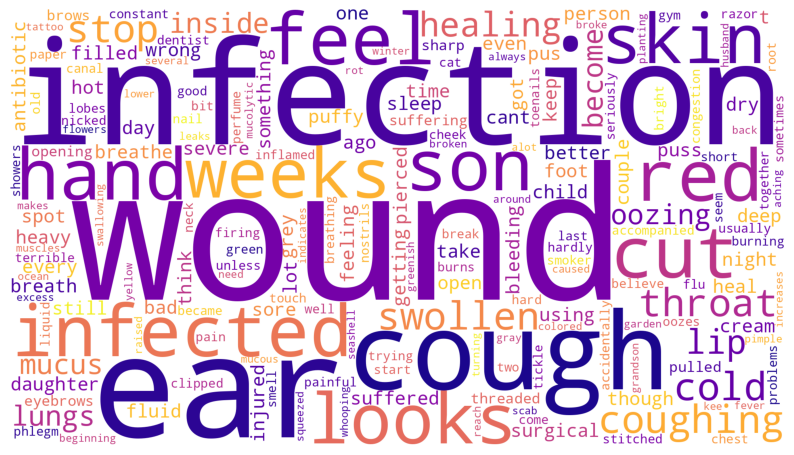

In [ ]:
plt.figure(figsize=(10,10))
wordCloudFunction(clean_df,'phrase',10000000)

In [ ]:
dummy_df

,accidentally,accompanied,aching,ago,alot,always,antibiotic,around,back,bad,...,usually,week,whooping,wrong,yellow,audio_clipping:confidence,background_noise_audible:confidence,quiet_speaker:confidence,overall_quality_of_the_audio,prompt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0000,1.0000,1.0,3.33,Infected wound
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1.0000,1.0000,1.0,4.67,Infected wound
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0000,0.6525,1.0,3.67,Infected wound
3,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1.0000,1.0000,1.0,4.00,Infected wound
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.6627,0.6627,1.0,4.00,Infected wound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0000,0.7357,1.0,3.50,Cough
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0000,0.7556,1.0,3.50,Cough
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0000,0.7397,1.0,3.50,Infected wound
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.7595,1.0000,1.0,4.00,Infected wound


In [ ]:
X=dummy_df.drop('prompt', axis = 1)
y=dummy_df['prompt']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

In [ ]:
scaler = StandardScaler().fit(x_train) # training the scaler model using the train set!
x_train_scaled = scaler.transform(x_train) # scaling the train set
x_test_scaled = scaler.transform(x_test) # scaling the train set

In [ ]:
log_reg_2 = LogisticRegression(random_state=1, solver = 'saga', max_iter = 100)  # max_iter = 100 - for improving convergence
                                                                                # For logistic regression with regularization one must choose 'saga' solver

parameters = {'penalty':['l1','l2'], # L1 penalty = Lasso, L2 penalty = Ridge
              'C': np.exp(np.arange(0,3,0.5))} # small C values means stronger regularization and the opposite

start = time()
log_reg_cv_2 = GridSearchCV(log_reg_2, parameters, cv=10, n_jobs=-1, scoring='accuracy',verbose=10).fit(x_train_scaled, y_train)
end = time()

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


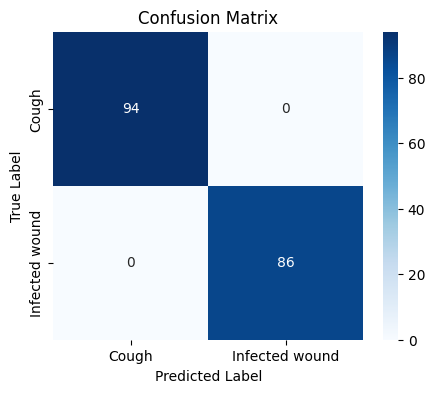

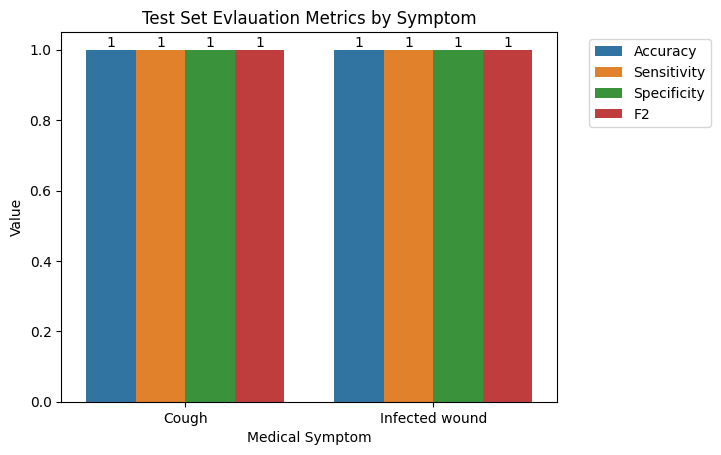

In [ ]:
log_2_train_acc, log_2_test_acc, classes, log_2_sensitivity, log_2_specificity = print_cm(log_reg_cv_2, x_train_scaled, x_test_scaled, y_train, y_test)

Logistic Regression running time = 0.371 minutes
Lasso best parameters: {'C': 1.0, 'penalty': 'l1'}
Lasso Train Accuracy: 1.0
Lasso Test Accuracy: 1.0


<Axes: xlabel='row_0', ylabel='prompt'>

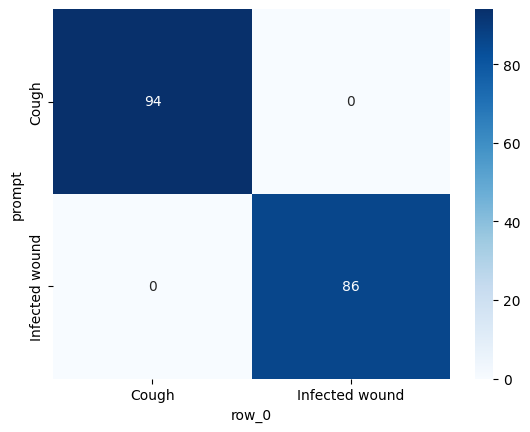

In [ ]:
print(f'Logistic Regression running time = {round((end-start)/60,3)} minutes')
print(f'Lasso best parameters: {log_reg_cv_2.best_params_}')
print(f'Lasso Train Accuracy: {round(np.mean(log_reg_cv_2.predict(x_train_scaled) == y_train),3)}')
print(f'Lasso Test Accuracy: {round(np.mean(log_reg_cv_2.predict(x_test_scaled) == y_test),3)}')
#plt.figure(figsize=(6, 10))
sns.heatmap(pd.crosstab(log_reg_cv_2.predict(x_test_scaled), y_test).T, cmap='Blues', annot=True)

In [ ]:
best_log=log_reg_cv_2.best_estimator_
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_log.coef_[0]})
coefficients_df['Coefficient'].sort_values(ascending=False)

Feature             cut
Coefficient    1.104262
Name: 39, dtype: object

In [ ]:
testing_class = EDAObject(filepath = "overview-of-recordings.csv", audio_dir = '/content/drive/MyDrive/Medical Speech Recordings/', binary_outcome=True)
#testing_class.get_data().head()
#testing_class.get_data().info()
#testing_class.EDA_quality_measures()
#testing_class.EDA_writers_speakers()
#testing_class.EDA_symptoms()
#testing_class.Correlation_Matrix()
testing_class.Add_audio_features(inplace = True)
testing_class.Clustering(n_components=5)

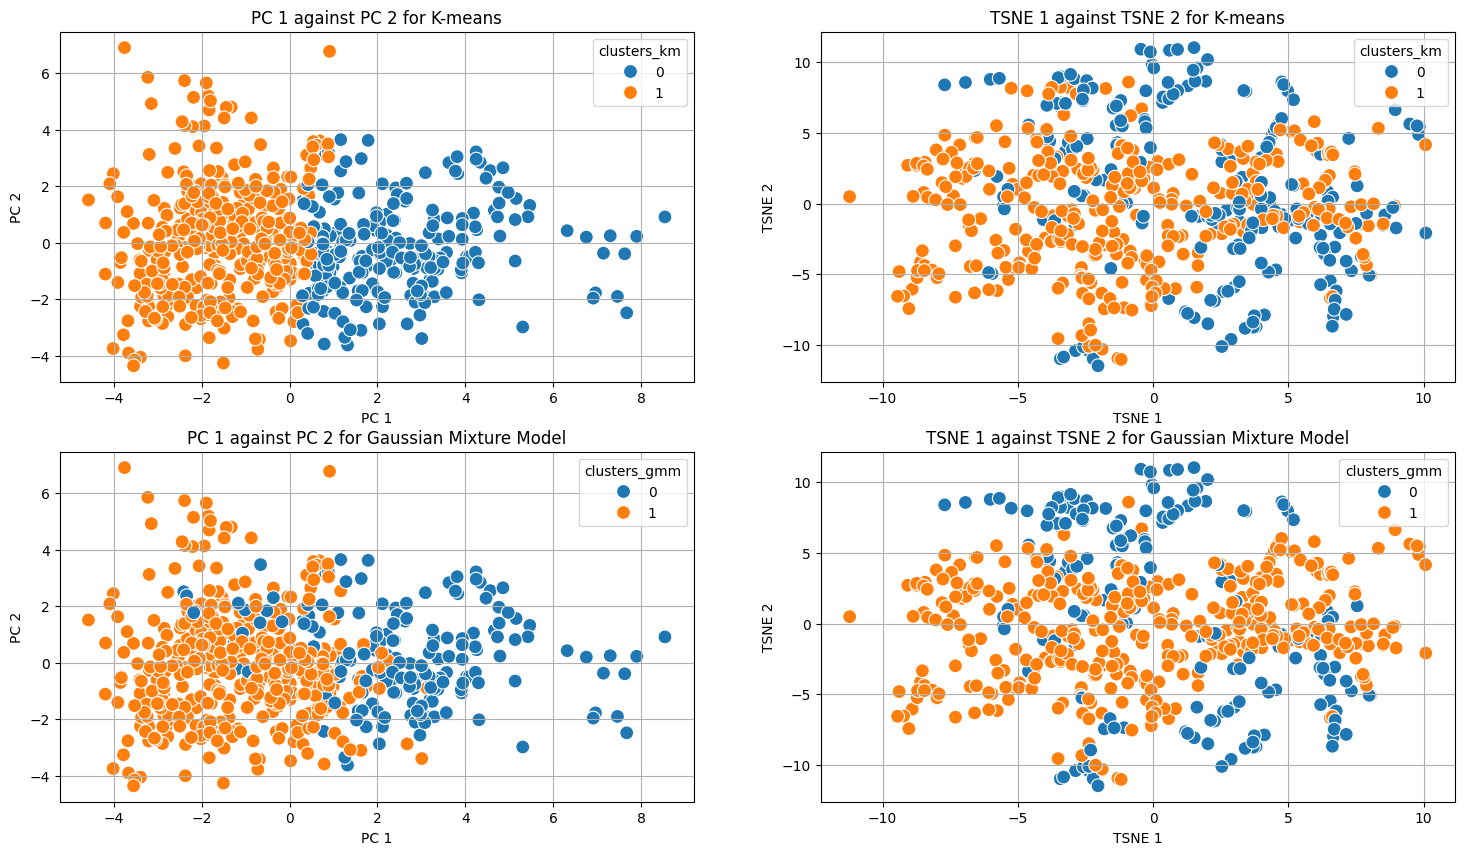

,audio_clipping:confidence,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker:confidence,duration,spectral_centroid_mean,spectral_centroid_std,zero_crossing_rate_mean,zero_crossing_rate_std,rms_energy_mean,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,clusters_gmm
0,1.0000,1.0000,3.33,1.0,3.413333,1835.024338,479.514200,0.070590,0.029885,0.119720,...,1.483515,0.353626,0.080681,0.303435,0.425117,-0.139892,-1.523462,0.162757,-0.059689,0
1,1.0000,1.0000,4.67,1.0,2.816009,1829.327075,1001.674679,0.135094,0.080350,0.052169,...,-1.132737,0.399725,-0.885306,-0.894762,-0.362383,-1.115793,-1.107771,-1.015430,-0.588674,1
2,1.0000,0.6525,3.67,1.0,1.365351,1541.884512,321.038251,0.077695,0.031605,0.014345,...,-0.312947,0.899051,-0.429282,-1.035037,-1.084525,-1.465790,-1.007789,-0.532408,-2.301504,1
3,1.0000,1.0000,4.00,1.0,10.495420,3423.069011,1365.141351,0.161900,0.131703,0.034643,...,0.590213,-0.332555,-0.652767,-0.950165,-1.392490,-1.287929,-0.993455,-1.184141,-1.094353,1
4,0.6627,0.6627,4.00,1.0,8.618685,2065.890427,798.783799,0.163695,0.100810,0.029455,...,0.443168,0.785950,-0.172410,-0.788161,-0.624884,-0.085371,-1.344795,-0.002319,-0.868969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1.0000,0.7357,3.50,1.0,1.792018,3274.913182,1264.129486,0.211789,0.132008,0.034006,...,-0.480093,-0.582183,-0.739260,-0.285373,-1.206451,-1.099336,-0.767141,-0.645883,-0.820888,1
595,1.0000,0.7556,3.50,1.0,3.584036,3099.755033,1551.763207,0.212358,0.151043,0.034121,...,-0.453825,-0.777533,-0.919764,-0.344128,-1.608418,-1.297295,-0.730209,-0.203125,-1.229187,1
596,1.0000,0.7397,3.50,1.0,7.801905,2535.768770,1532.707499,0.155089,0.148703,0.052776,...,-0.244349,-0.961790,0.200730,-1.154310,-1.102787,-0.758789,-1.714085,-1.421097,-1.561385,1
597,0.7595,1.0000,4.00,1.0,9.301361,1798.169462,1029.977754,0.119639,0.105033,0.048127,...,-1.230015,-1.219790,-0.648303,-1.113168,-1.542363,-0.289813,-1.718533,-1.104027,-0.493453,0


In [ ]:
testing_class.Clustering(n_components=5)

In [ ]:
X = pd.read_csv('X.csv').drop(columns=['Unnamed: 0'])
y = pd.read_csv('y.csv')['prompt']

In [ ]:
testing_class = modelingObject(X,y)
testing_class.split_scale_data()
testing_class.train_models()
testing_class.test_models()

In [ ]:
testing_class.results(show_df=True)

In [ ]:
testing_class.plot_tree()